## Load in Library

In [2]:
from functions.pytorch_assist_functions import *

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import optimizer
import torch.nn.utils as utils
import torch.nn.functional as F


import onnx
import onnxruntime as ort
# from onnx2pytorch import ConvertModel  #(THIS ONE RELLY SUCKS DONT USE IT, it ENFORCES BATCH SIZE = 1 )
from onnx2torch import convert

from tqdm import tqdm
import sys
import pickle

# Resize Image
def load_and_resize(path, mask = False):
    vol = nib.load(path).get_fdata()
    vol = torch.tensor(vol, dtype=torch.float32)

    vol = vol.permute(2, 0, 1)  # Change to (X, Y,Z) -> (Z,X,Y)
    vol = vol.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions: (1, 1, Z, X, Y)
    if mask == False:
        resized_vol = F.interpolate(vol, size=(vol.shape[2], 200, 200), mode='trilinear', align_corners=False)
    elif mask == True:
        resized_vol = F.interpolate(vol, size=(vol.shape[2], 200, 200), mode='nearest')
    resized_vol = resized_vol.squeeze(0).squeeze(0)
    resized_vol = resized_vol.unsqueeze(-1)
    return resized_vol

def dice_score(pred, target, smooth=1e-6):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def get_learning_rate(num_epochs = 100, max_epochs = 100):
    # Your ONNX model path
    onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
    onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
    onnx.checker.check_model(onnx_model)  # Check if the model is valid
    pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

    # Suppose 'scheduler' is your learning rate scheduler and 'optimizer' is your optimizer
    optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
    scheduler = PolyLRScheduler(optimizer, max_epochs=  max_epochs, power=0.9)
    # Save the learning rate for each epoch in a list
    learning_rates = []
    for epoch in range(num_epochs):
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
        learning_rates.append(lr)
    #print("Learning rates for each epoch:", learning_rates)
    return learning_rates

def normalize_slicewise_minmax(volume: np.ndarray, axis: int = 0, eps: float = 1e-8) -> np.ndarray:
    """
    Slice-wise min-max normalization to [0,1].
    
    Parameters
    ----------
    volume : np.ndarray
        3D array, e.g. (Z, X, Y) for MRI.
    axis : int
        Axis along which slices are normalized independently.
    eps : float
        Small value to avoid divide-by-zero.
    
    Returns
    -------
    np.ndarray
        Normalized volume with values in [0,1].
    """
    v = np.asarray(volume, dtype=np.float32)

    # Compute per-slice min and max along given axis
    lo = np.min(v, axis=(1,2), keepdims=True) if axis == 0 else np.min(v, axis=axis, keepdims=True)
    hi = np.max(v, axis=(1,2), keepdims=True) if axis == 0 else np.max(v, axis=axis, keepdims=True)

    rng = np.maximum(hi - lo, eps)
    out = (v - lo) / rng
    return out.astype(np.float32)
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation Functions

In [2]:
import torch
import random
import torchvision.transforms.v2 as T  # Ensure using v2
import kornia.augmentation as K
from torch.utils.data import DataLoader, Dataset

# Augmentations that should be applied to both images & masks
spatial_augmentations = torch.nn.Sequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomAffine(degrees=10, scale=(0.9, 1.1), p=  .5, resample= "nearest"),  # Rotation & scaling
    #K.RandomElasticTransform(alpha=(2, 2), sigma=(10, 10), p=.2),  # Elastic deformation (Optional)
    K.RandomCrop(size=(200, 200), p = .75),  # Random crop
)

# Augmentations specific to images (not masks)
intensity_augmentations = T.Compose([
    T.Lambda(lambda img: img + random.uniform(-0.3, 0.3)),  # Channel shift
])


class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform_spatial=None, transform_intensity=None):
        self.images = images  # Expect (D, W, H, C) NumPy array
        self.labels = labels
        self.transform_spatial = transform_spatial
        self.transform_intensity = transform_intensity

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, mask = self.images[idx], self.labels[idx]  # (H, W, C)

       # Convert to PyTorch tensor and reorder to (C, H, W)
        #img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
        img = img.detach().clone().permute(2,0,1).to(torch.float32)  # Ensure float32 type

        # Convert mask to PyTorch tensor and reorder to (C, H, W) if mask is also in (H, W, C)
        #mask = torch.tensor(mask, dtype=torch.uint8).permute(2, 0, 1)  # (C, H, W)
        mask = mask.detach().clone().permute(2,0,1)
        # Apply spatial transformations to both image and mask
        if self.transform_spatial:
            stacked = torch.cat([img, mask], dim=0)  # Now (C + C, H, W)
            stacked = self.transform_spatial(stacked)  # Apply transformations

            # Split back into image and mask
            img, mask = stacked[0,0,:,:], stacked[0,1,:,:]  # Split back

        if self.transform_intensity:
            img = self.transform_intensity(img)  # Apply intensity transformations to image


        # Ensure mask is in the correct format (B, H, W,C) for loss functions
        img = img.unsqueeze(2)
        mask = mask.unsqueeze(2)


        # Ensure mask remains binary
        mask = (mask > 0.5).float()
        return img, mask

# Load in Model and Look at Model Structure

In [3]:
# Move all X and y to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your ONNX model path
#onnx_model_path = "C:/Users/Bruger/sct_6.4/data/deepseg_gm_models/large_model.onnx"

onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
# Load the ONNX model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

# Convert the ONNX model to a PyTorch model
#pytorch_model_temp = ConvertModel(onnx_model)

pytorch_model_temp = convert(onnx_model)

In [11]:
example_input = torch.randn(4, 200, 200, 1)  # Batch size 4

try:
    output = pytorch_model_temp(example_input)
    print("Model works with batch size >1!")
except Exception as e:
    print("Batching issue:", e)

Model works with batch size >1!


In [149]:
# Get model inputs
for input_tensor in onnx_model.graph.input:
    print(f"Input Name: {input_tensor.name}")
    tensor_type = input_tensor.type.tensor_type
    shape = [dim.dim_value for dim in tensor_type.shape.dim]  # Get dimensions
    print(f"Input Shape: {shape}")

# Create a dummy input with batch size of 1 (replace 0 with a specific batch size)
dummy_input = torch.randn(20, 200, 200, 1)  # Batch size 1, 1 channel, 200x200 image

# Pass it to the model (make sure to adjust the shape if needed)
output = pytorch_model_temp(dummy_input)

print("Output Shape:", output.shape)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total_params(model):
    return sum(p.numel() for p in model.parameters())

# Example:
print(f"Trainable parameters: {count_trainable_params(pytorch_model_temp):,}")
print(f"Total parameters: {count_total_params(pytorch_model_temp):,}")

Input Name: input_1
Input Shape: [0, 200, 200, 1]
Output Shape: torch.Size([20, 200, 200, 1])
Trainable parameters: 475,329
Total parameters: 475,329


In [160]:
############ Check Weights ######
for name, param in pytorch_model_temp.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}, Requires Grad: {param.requires_grad}")
    print(f"Sample Value: {param.data[0]}")


####### See Layer Architecture #####
print(pytorch_model_temp)

Layer: conv2d_1.weight, Shape: torch.Size([64, 1, 3, 3]), Requires Grad: True
Sample Value: tensor([[[-0.0437, -0.0035,  0.0577],
         [-0.1536,  0.0827,  0.0304],
         [-0.1389, -0.1714, -0.0146]]])
Layer: conv2d_1.bias, Shape: torch.Size([64]), Requires Grad: True
Sample Value: -0.6189233660697937
Layer: batch_normalization_1.weight, Shape: torch.Size([64]), Requires Grad: True
Sample Value: 0.8934211730957031
Layer: batch_normalization_1.bias, Shape: torch.Size([64]), Requires Grad: True
Sample Value: -0.07164237648248672
Layer: conv2d_2.weight, Shape: torch.Size([64, 64, 3, 3]), Requires Grad: True
Sample Value: tensor([[[-2.6718e-01,  4.8152e-02, -4.0044e-01],
         [-2.5803e-01, -2.9867e-01, -3.6874e-01],
         [-2.4621e-01, -2.3673e-01, -2.6119e-01]],

        [[ 2.4971e-01, -8.8108e-02,  1.0428e-01],
         [ 2.9166e-02, -5.1724e-01, -1.3651e-01],
         [ 2.7882e-01, -2.1339e-01, -2.4597e-01]],

        [[-3.4651e-01, -3.7732e-01, -3.5453e-01],
         [-4.9

# Load in Data and Put in DataLoader format

In [3]:
### Resize The Images
path = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/masked_gibbs_denoised_stitched_spinal_cord.nii.gz"
path_wm_mask = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/wm.nii.gz"
path_gm_mask = "C:/DTI_SC/humanSC_400h/Simon FODs/hsc2_structural_data_and_gmwm_masks/gm.nii.gz"

images_data = load_and_resize(path = path ,mask = False)
labels_gm_data = load_and_resize(path = path_gm_mask, mask = True)
labels_wm_data = load_and_resize(path = path_wm_mask, mask = True)


np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/resized_masked_gibbs_denoised_stitched_spinal_cord_200_200.npy", images_data)
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_gm_mask_200_200.npy", labels_gm_data)
np.save("Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_wm_mask_200_200.npy", labels_wm_data)

# Remove slices from images_data and labels_data for specific z-values
# For example, remove slices from index 0 to 95 and from -1 to -15
# Remove slices from index 0 to 95
images_data = np.delete(images_data, np.s_[0:100], axis=0)
labels_gm_data = np.delete(labels_gm_data, np.s_[0:100], axis=0)
labels_wm_data = np.delete(labels_wm_data, np.s_[0:100], axis=0)

# Remove slices from index -1 to -15
images_data = np.delete(images_data, np.s_[-40:], axis=0)
labels_gm_data = np.delete(labels_gm_data, np.s_[-40:], axis=0)
labels_wm_data = np.delete(labels_wm_data, np.s_[-40:], axis=0)

print(f"New shape of images_data: {images_data.shape}")
print(f"New shape of labels GM data: {labels_gm_data.shape}")
print(f"New shape of labels WM data: {labels_wm_data.shape}")

### Intensity Normalization ###
images_data = normalize_slicewise_minmax(images_data, axis=0)

#Turn into Tensor
images_tensor = torch.tensor(images_data, dtype=torch.float32)
labels_gm_tensor = torch.tensor(labels_gm_data, dtype=torch.float32)
labels_wm_tensor = torch.tensor(labels_wm_data, dtype=torch.float32)



#### Test and Train Split
print("---- Starting Train, validation, test split ----")
from sklearn.model_selection import train_test_split  # Import train_test_split

# Assuming `images_tensor`, `labels_gm_tensor`, and `labels_wm_tensor` are PyTorch tensors
# Split the dataset into train and test sets for both GM and WM labels

# Suppose you have N slices
num_samples = len(images_tensor)
# Create array of indices
indices = np.arange(num_samples)

# Assuming `images_tensor`, `labels_gm_tensor`, and `labels_wm_tensor` are PyTorch tensors
# Split the dataset into train and test sets for both GM and WM labels

# Step 1: Split the dataset into train and test sets (80% train, 10% test, 10% validation)
train_idx, test_idx_temp  = train_test_split(indices, test_size=0.2, random_state=42)

# Step 2: Split the training data into train and validation sets (90% train, 10% validation)
test_idx, val_idx_idx = train_test_split(test_idx_temp, test_size=0.5, random_state=42)


# Use indices to split the data
X_train = images_tensor[train_idx]
X_test = images_tensor[test_idx]
X_val = images_tensor[val_idx_idx]

y_train_gm = labels_gm_tensor[train_idx]
y_test_gm = labels_gm_tensor[test_idx]
y_val_gm = labels_gm_tensor[val_idx_idx]

y_train_final_wm = labels_wm_tensor[train_idx]
y_test_wm = labels_wm_tensor[test_idx]
y_val_wm = labels_wm_tensor[val_idx_idx]


########################## DataLoader ##########################
# Create a TensorDataset for the full dataset
dataset_full_gm = TensorDataset(images_tensor, labels_gm_tensor)
full_loader_gm = DataLoader(dataset_full_gm, batch_size= 15)

dataset_full_wm = TensorDataset(images_tensor, labels_wm_tensor)
full_loader_wm = DataLoader(dataset_full_wm, batch_size= 15)

# Create a TensorDataset for GM Train, Validation and Test Split
dataset_train_gm = TensorDataset(X_train, y_train_gm)
train_loader_gm = DataLoader(dataset_train_gm, batch_size = 15)

dataset_val_gm = TensorDataset(X_val, y_val_gm)
validation_loader_gm = DataLoader(dataset_val_gm)

dataset_test_gm = TensorDataset(X_test, y_test_gm)
test_loader_gm = DataLoader(dataset_test_gm)

# Create a TensorDataset for WM Train, Validation and Test Split
dataset_train_wm = TensorDataset(X_train, y_train_final_wm)
train_loader_wm = DataLoader(dataset_train_wm, batch_size = 15)

dataset_val_wm = TensorDataset(X_val, y_val_wm)
validation_loader_wm = DataLoader(dataset_val_wm)

dataset_test_wm = TensorDataset(X_test, y_test_wm)
test_loader_wm = DataLoader(dataset_test_wm)


# Create dataset & DataLoader for the AUGMENTED dataset
dataset_augmented_gm = AugmentedDataset(
    images = X_train, 
    labels = y_train_gm, 
    transform_spatial = spatial_augmentations, 
    transform_intensity = intensity_augmentations
)

dataset_augmented_wm = AugmentedDataset(
    images = X_train, 
    labels = y_train_final_wm, 
    transform_spatial = spatial_augmentations, 
    transform_intensity = intensity_augmentations
)

# Create DataLoader for the augmented dataset
Train_loader_gm_augment = DataLoader(dataset_augmented_gm, batch_size=15, shuffle=True)
Train_loader_wm_augment = DataLoader(dataset_augmented_wm, batch_size=15, shuffle=True)

New shape of images_data: torch.Size([1779, 200, 200, 1])
New shape of labels GM data: torch.Size([1779, 200, 200, 1])
New shape of labels WM data: torch.Size([1779, 200, 200, 1])
---- Starting Train, validation, test split ----


C:\Users\sigur\AppData\Local\Temp\ipykernel_14256\778771439.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_gm_tensor = torch.tensor(labels_gm_data, dtype=torch.float32)
C:\Users\sigur\AppData\Local\Temp\ipykernel_14256\778771439.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_wm_tensor = torch.tensor(labels_wm_data, dtype=torch.float32)


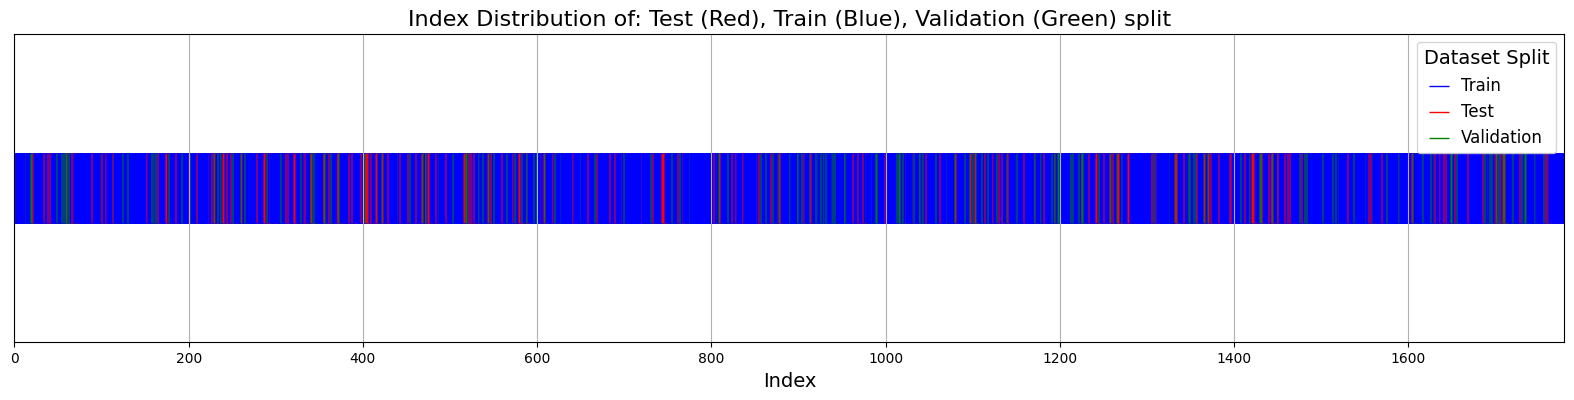

In [140]:
# Create a list of colors for each index
colors = ['red' if idx in test_idx else 'blue' if idx in train_idx else 'green' for idx in indices]

# Create a scatter plot with a larger figure size and bigger markers
plt.figure(figsize=(20, 4))  # Increase figure size
plt.scatter(indices, [0] * len(indices), c=colors, s=200, marker='_', linewidths=50)  # Increase marker size and use '_' for taller lines

# Add legend for colors
plt.scatter([], [], c='blue', label='Train', s=200, marker='_', linewidths=1)
plt.scatter([], [], c='red', label='Test', s=200, marker='_', linewidths=1)
plt.scatter([], [], c='green', label='Validation', s=200, marker='_', linewidths=1)  # Match linewidths with red and blue
plt.legend(title="Dataset Split", fontsize=12, title_fontsize=14, markerscale = 1, handlelength=1)

# Add labels and legend
plt.title("Index Distribution of: Test (Red), Train (Blue), Validation (Green) split", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.xlim(0, num_samples)  # Set x-axis limits to the number of samples
plt.yticks([])  # Remove y-axis ticks
plt.grid(True)
plt.show()

#### Visual Inspection of Data

In [ ]:
# Example image and label paths
images_paths = ["Simon FODs/hsc2_structural_data_and_gmwm_masks/resized_masked_gibbs_denoised_stitched_spinal_cord_200_200.npy"]
labels_gm_paths = ["Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_gm_mask_200_200.npy"]  # Replace with actual paths
labels_wm_paths = ["Simon FODs/hsc2_structural_data_and_gmwm_masks/slices_wm_mask_200_200.npy"]  # Replace with actual paths


#Load in Image
images_data = np.load(images_paths[0])
labels_gm_data = np.load(labels_gm_paths[0])
labels_wm_data = np.load(labels_wm_paths[0])


SC_mask = np.load("Simon FODs/hsc2_structural_data_and_gmwm_masks/mask_t2_200_200.npy")

images_data_norm = normalize_slicewise_minmax(images_data.squeeze(), axis=0)

plt.subplot(1,3,1)
plt.imshow(images_data[200,:,: ], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(images_data_norm[200,:,:], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(SC_mask[200,:,:])


C:\Users\Bruger\AppData\Local\Temp\ipykernel_22592\968143623.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_22592\968143623.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.uint8).permute(2, 0, 1)  # (C, H, W)


[0. 1.]


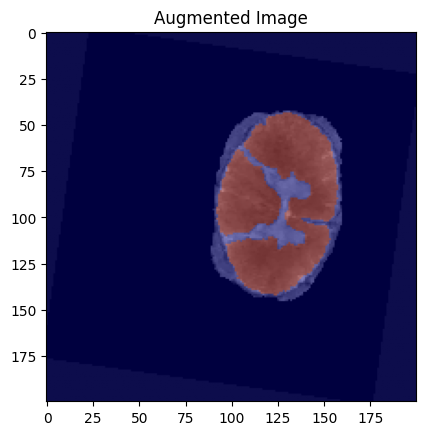

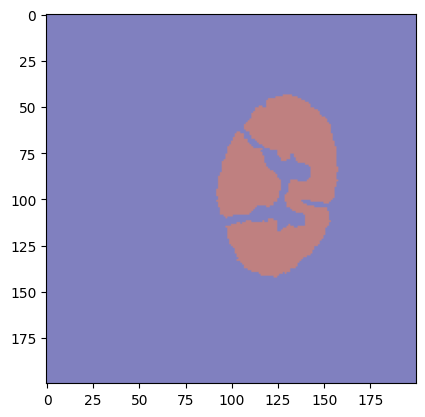

In [8]:
### Test the augmentation pipeline ###
# Get one batch of augmented images
data_iter = iter(Train_loader_wm_augment)
batch_images, batch_labels = next(data_iter)

# Convert tensors to NumPy for visualization
img = batch_images[0].squeeze().cpu().numpy()  # Get first image in batch
label = batch_labels[0].squeeze().cpu().numpy()  # Get corresponding label
print(np.unique(label))  # Check unique values in the label

# Show image
plt.imshow(img, cmap='gray')
plt.imshow(label, cmap='jet', alpha=0.5)  # Overlay label on image
plt.title("Augmented Image")
plt.show()

plt.imshow(label, cmap='jet', alpha=0.5)  # Overlay label on image

## Intial Predciton Before Training

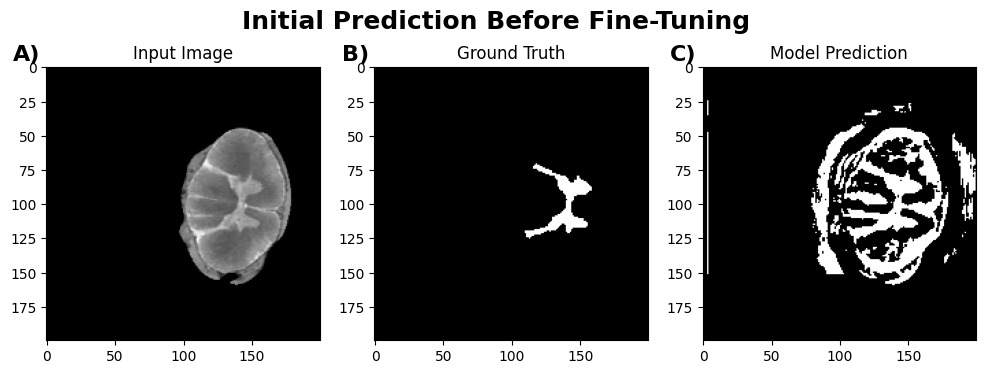

In [4]:
#### Inital Preidction Before Fine-Tuning Model #####

# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
# Load the ONNX model
onnx_model = onnx.load(onnx_model_path)

# Check if the model is valid
onnx.checker.check_model(onnx_model)

# Convert the ONNX model to a PyTorch model
pytorch_model = convert(onnx_model)

pytorch_model = pytorch_model.cpu()  # Move model to the same device as input

z = 200

z = 200
input_slice = X_train[z].unsqueeze(0).cpu()   # move input to CPU
output = pytorch_model(input_slice)

label = torch.where(output > 0.5, 1,0)


fig, axes = plt.subplots(1, 3, figsize=(12 ,4))
axes[0].imshow(X_train[z, :, :, 0].cpu(), cmap='gray')
axes[0].set_title("Input Image")
axes[0].text(-0.12, 1.08, "A)", transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

axes[1].imshow(y_train_gm[z, :, :, 0].cpu(), cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].text(-0.12, 1.08, "B)", transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

axes[2].imshow(label[0, :, :, 0].cpu(), cmap='gray')
axes[2].set_title("Model Prediction")
axes[2].text(-0.12, 1.08, "C)", transform=axes[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
plt.suptitle("Initial Prediction Before Fine-Tuning", fontsize=18, fontweight='bold')

plt.savefig("figures/CNN_GM_initial_prediction_before_fine_tuning.svg", dpi = 300)
plt.show()


# Training of the model

In [5]:
# DEFINE FUNCTIONS FOR TRAIN AND LOAD MODEL
from tqdm import tqdm
import os

def train_model(pytorch_model, train_loader, val_loader, criterion,
                    optimizer, scheduler, start_epoch=0, max_epochs=20, device='cpu',
                    save_path_model=None, patience=5, min_delta=1e-4):
    pytorch_model.train()
    pytorch_model = pytorch_model.to(device)
    epoch_metrics = []  # List to store metrics for each epoch

    parent_dir = os.path.dirname(save_path_model)
    if not os.path.exists(parent_dir):
        print(f"Creating directory: {parent_dir}")
        os.makedirs(parent_dir)

    best_val_loss = float('inf')

    for epoch in range(start_epoch, max_epochs):  # Start from last saved epoch
        pytorch_model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", unit="batch")

        for batch_idx, (data, target) in enumerate(progress_bar):
            batch_images = data.to(device)
            batch_labels = target.to(device)

            # Forward pass
            outputs = pytorch_model(batch_images)
            loss = criterion(outputs, batch_labels)

            # Backward pass
            loss.backward()
            running_loss += loss.item()

            # Change weights and zero gradients 
            optimizer.step()
            optimizer.zero_grad()

            # Update tqdm description dynamically
            progress_bar.set_postfix({"Train Loss": f"{loss.item():.4f}"})

        #--------------- Scheduler step ----------------------#
        scheduler.step()
        print(f"Epoch {epoch+1}: Learning Rate = {scheduler.get_last_lr()[0]:.6f}")
        print(f"Epoch [{epoch+1}/{max_epochs}], Average Loss: {running_loss/len(train_loader):.4f}")
        
        # Validation Set evaluation
        y_train_bin_prediction, outputs_probability_tensor, avg_val_loss, accuracy = validation_test(pytorch_model, 
                                                                                                   val_loader = val_loader,
                                                                                                   criterion=criterion, 
                                                                                                   device = device,
                                                                                                   threshold= 0.5)
        y_val = val_loader.dataset.tensors[1].cpu()
        metrics_val = calculate_metrics(predictions = outputs_probability_tensor,
                    targets = y_val, criterion = criterion, device= device)

        
        val_loss = metrics_val['loss']  #if 'loss' in metrics_val else criterion(y_val_pred, y_val).item()
        metrics_val['epoch'] = epoch + 1
        metrics_val['train_loss'] = running_loss / len(train_loader)

        ###### Append metrics for the current epoch #####
        epoch_metrics.append(metrics_val)
        print(f"Validation: Epoch [{epoch+1}/{max_epochs}], Metrics: {metrics_val}")
        # Add the epoch_metrics as an attribute to pytorch_model
        pytorch_model.validation_history = epoch_metrics




        #### Save model checkpoint ##### 
        output_path = save_path_model + f'{epoch}of{max_epochs}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': pytorch_model.state_dict(),
            'validation_history': pytorch_model.validation_history,
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss.item(),
        }, output_path)
    



        # -------- Early Stopping --------
        if val_loss < (best_val_loss - min_delta):
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save best model
            #best_model_path = save_path_model + f'best_epoch{epoch+1}.pth'
            #torch.save(pytorch_model.state_dict(), best_model_path)
            print(f"------ Validation loss improved to {val_loss:.4f} -------")
        else:
            epochs_no_improve += 1
            print(f"------ No improvement for {epochs_no_improve} epoch(s). -----")

        if epochs_no_improve >= patience:
            print(f"--####--Early stopping triggered at epoch {epoch+1}. Best loss: {best_val_loss:.4f} --####--")
            break


    print("Training complete.")
    return pytorch_model


def validation_test(model ,val_loader, criterion, device = "cpu" ,threshold = 0.5):

    # Check if GPU is available
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pytorch_model = model.to(device = device)
    print(f"Running on {device}")

    #Load model Weights
    pytorch_model.eval()  # Set the model to evaluation mode


    #Setup Data Structures:
    y_test_prediction = []  # Initialize a list to store predictions
    all_outputs = []  # Initialize a list to store all outputs

    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        false_positive = 0
        false_negative = 0
        true_positive = 0
        true_negative = 0

        for batch_idx, (batch_image, batch_labels) in enumerate(val_loader):
            batch_image = batch_image.to(device)  # Move to device
            batch_labels = batch_labels.to(device)  # Move to device

            # Model output
            outputs = pytorch_model(batch_image)
            all_outputs.append(outputs)  # Save the output

            # Apply threshold to get binary predictions
            predicted = torch.where(outputs > threshold, 1, 0)

            # Save predictions
            y_test_prediction.append(predicted.cpu().numpy())

            # Loss
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()

            total += batch_labels.numel()
            correct += (predicted == batch_labels).sum().item()

            false_positive += ((predicted == 1) & (batch_labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (batch_labels == 1)).sum().item()
            true_positive += ((predicted == 1) & (batch_labels == 1)).sum().item()
            true_negative += ((predicted == 0) & (batch_labels == 0)).sum().item()

        # Metrics
        avg_val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total

        print(f"False Positive: {false_positive}")
        print(f"False Negative: {false_negative}")
        print(f"True Positive: {true_positive}")
        print(f"True Negative: {true_negative}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.2f}%")

    # Convert y_test_prediction to a NumPy array and remove the second dimension
    y_test_prediction = np.squeeze(np.array(y_test_prediction))

    # Convert all_outputs to a tensor
    probablity_outputs = torch.cat(all_outputs, dim=0)

    return y_test_prediction, probablity_outputs, avg_val_loss, accuracy


def load_model(pytorch_model, optimizer, scheduler, load_path_model, device="cpu"):
    # Load the saved checkpoint
    checkpoint = torch.load(load_path_model, map_location=device,  weights_only= False)

    # Load model state dictionary
    pytorch_model.load_state_dict(checkpoint['model_state_dict'])
    pytorch_model = pytorch_model.to(device)
    
    try:
        pytorch_model.validation_history = checkpoint["validation_history"]
    except KeyError:
        print("No validation history found in the checkpoint.")

    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load scheduler state and manually set last_epoch
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scheduler.last_epoch = checkpoint['epoch']  # Ensure it continues from the correct epoch

    last_epoch = checkpoint['epoch']

    print(f"Model loaded successfully from: {load_path_model}")
    print(f"Resuming training from epoch {last_epoch + 1}")

    return pytorch_model, optimizer, scheduler, last_epoch

## GM Segmentation

In [ ]:
### Final Model ####
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

max_epochs = 100
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_gm_augment,
            val_loader =  validation_loader_gm, 
            criterion = dice_loss, 
            optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001), 
            scheduler = PolyLRScheduler(optimizer, max_epochs, power=0.9),
            max_epochs = max_epochs,
            start_epoch= 0,
            device = device, 
            save_path_model= 'Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_',
            patience= 8)

In [ ]:
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")


max_epochs = 100
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_gm_augment,
            test_loader = validation_loader_gm, 
            criterion = dice_loss, 
            optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001), 
            scheduler = PolyLRScheduler(optimizer, max_epochs, power=0.9),
            max_epochs = max_epochs,
            start_epoch= 0,
            device = device, 
            save_path_model= 'Segmentation Models/GM_augmented_data/sct_deepseg_gm_augmented_intensity_norm_data_')

In [ ]:
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")


max_epochs = 100
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_gm_augment,
            test_loader = validation_loader_gm, 
            criterion = dice_loss, 
            optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001), 
            scheduler = PolyLRScheduler(optimizer, max_epochs, power=0.9),
            max_epochs = max_epochs,
            start_epoch= 0,
            device = device, 
            save_path_model= 'Segmentation Models/GM_augmented_data/sct_deepseg_gm_augmented_intensity_norm_data_')

**Training Stopped Mid Epoch so continuing from last known epoch**

In [ ]:
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = pytorch_model.to(device= device)
print(f"Running on {device}")


checkpoint = torch.load("C:/DTI_SC/humanSC_400h/Segmentation Models/sct_deepseg_gm_augmented_data_100_epochs.pth", weights_only= False)

# 2. Restore optimizer and scheduler if continuing training
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


scheduler = PolyLRScheduler(optimizer, max_epochs=100, power=0.9)
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# 3. Optional: restore epoch to continue training
start_epoch = checkpoint['epoch'] + 1
pytorch_model.validation_history = checkpoint["validation_history"]


# 4. Load the model state dictionary
pytorch_model.load_state_dict(checkpoint['model_state_dict'])
pytorch_model = pytorch_model.to(device= device)
print(f"Model loaded successfully from: {checkpoint['model_state_dict']}")

print(f"Resuming training from epoch {start_epoch + 1}")

# 5. Continue training or evaluation as needed
# Example: continue training
trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_gm_augment,
            test_loader= validation_loader_gm, 
            criterion = dice_loss, 
            optimizer = optimizer, 
            scheduler = scheduler,
            max_epochs = 100 ,
            start_epoch= start_epoch ,
            device = device, 
            save_path_model= 'Segmentation Models/GM_augmented_data/sct_deepseg_gm_augmented_data_')

In [ ]:
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

max_epochs = 50
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = full_loader_gm,
            test_loader= None, 
            criterion = dice_loss, 
            optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001), 
            scheduler = PolyLRScheduler(optimizer, max_epochs, power=0.9),
            max_epochs = max_epochs,
            device = device, 
            save_path_model= f'Segmentation Models/GM_full_data_{max_epochs}/sct_deepseg_gm_fine_tuned_full_data_.pth')



### Validation Hyperparameter Tuning and Plots

In [10]:
############## Find the optimal quantizer function for classification ############
val_gm_mask, val_gm_mask_prob = predict_and_visualize(data_tensor = dataset_val_gm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= 0.5)

y_true_gm = dataset_val_gm.tensors[1].cpu().numpy().flatten()
y_probs_gm = val_gm_mask_prob.cpu().numpy().flatten()



# Youden's J
best_thresh_GM_youden = find_best_youden_threshold(y_true_gm, y_probs_gm)
print(f"Best Threshold (Youden's J): {best_thresh_GM_youden:.3f}")

# MCC
best_thresh_GM_MCC = find_best_mcc_threshold(y_true_gm, y_probs_gm)
print(f"Best Threshold (MCC): {best_thresh_GM_MCC:.3f}")

#F1 Threshold
best_threshold_GM_f1, best_f1_GM = find_best_f1_threshold(y_true = y_true_gm, y_probs = y_probs_gm)

import pickle

# Save the variables to a file
with open('Segmentation Models/thresholds/best_thresholds_GM.pkl', 'wb') as f:
    pickle.dump({
        'best_f1_GM': best_threshold_GM_f1,
        'best_thresh_GM_MCC': best_thresh_GM_MCC,
        'best_thresh_GM_youden': best_thresh_GM_youden
    }, f)
print("Thresholds saved successfully.")

best_threshold_GM_f1, best_thresh_GM_MCC,  best_thresh_GM_youden

Running on cuda
starting new
Best Threshold (Youden's J): 0.000
Trying Threshold: 0.0
Trying Threshold: 0.010101010101010102
Trying Threshold: 0.020202020202020204
Trying Threshold: 0.030303030303030304
Trying Threshold: 0.04040404040404041
Trying Threshold: 0.05050505050505051
Trying Threshold: 0.06060606060606061
Trying Threshold: 0.07070707070707072
Trying Threshold: 0.08080808080808081
Trying Threshold: 0.09090909090909091
Trying Threshold: 0.10101010101010102
Trying Threshold: 0.11111111111111112
Trying Threshold: 0.12121212121212122
Trying Threshold: 0.13131313131313133
Trying Threshold: 0.14141414141414144
Trying Threshold: 0.15151515151515152
Trying Threshold: 0.16161616161616163
Trying Threshold: 0.17171717171717174
Trying Threshold: 0.18181818181818182
Trying Threshold: 0.19191919191919193
Trying Threshold: 0.20202020202020204
Trying Threshold: 0.21212121212121213
Trying Threshold: 0.22222222222222224
Trying Threshold: 0.23232323232323235
Trying Threshold: 0.24242424242424243

(np.float64(0.23232323232323235),
 np.float64(0.23232323232323235),
 np.float32(1.4726721e-06))

**PLOT For the GM Segmentation:**

In [49]:
####  Load the saved thresholds  GM ####
with open('Segmentation Models/thresholds/best_thresholds_GM.pkl', 'rb') as f:
    thresholds_gm = pickle.load(f)

# Unpack them into variables if needed
best_threshold_GM_f1 = thresholds_gm['best_f1_GM']
best_thresh_GM_MCC = thresholds_gm['best_thresh_GM_MCC']
best_thresh_GM_youden = thresholds_gm['best_thresh_GM_youden']
print(f"Best Threshold (Youden's J): {best_thresh_GM_youden:.3f}")
print(f"Best Threshold (MCC): {best_thresh_GM_MCC:.10f}")
print(f"Best Threshold (F1): {best_threshold_GM_f1:.10f}")

#### Validation SET ######
val_gm_mask, val_gm_mask_prob = predict_and_visualize(data_tensor = dataset_val_gm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= best_threshold_GM_f1)
y_true_gm = dataset_val_gm.tensors[1].cpu().numpy()


###### Confusion Matrix #########
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten the arrays for confusion matrix calculation
y_pred_flat = val_gm_mask.flatten()
y_true_flat = y_true_gm.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Calculate percentages
tn, fp, fn, tp = cm.ravel()

TPR = tp / (tp + fn) *100 if (tp + fn) > 0 else 0
TNR = tn / (tn + fp) *100 if (tn + fp) > 0 else 0
FPR = fp / (fp + tn) *100 if (fp + tn) > 0 else 0
FNR = fn / (fn + tp) *100 if (fn + tp) > 0 else 0

classes = ["Non-GM", "GM"]

# Add text with percentages
textstr = (
    f"TPR: {TPR:.2f}% (Sensitivity)\n"
    f"FPR: {FPR:.2f}% (1-Specificity)\n"
    f"TNR: {TNR:.2f}% (Specificity)\n"
    f"FNR: {FNR:.2f}% (1-Sensitivity)"
)

########## Test Dataset ########

test_gm_mask, test_gm_mask_prob = predict_and_visualize(data_tensor = dataset_test_gm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= best_threshold_GM_f1)
y_test_true_gm = dataset_test_gm.tensors[1].cpu().numpy()

# Flatten the arrays for confusion matrix calculation
y_test_pred_flat = test_gm_mask.flatten()
y_test_true_flat = y_test_true_gm.flatten()

# Compute confusion matrix
cm_test = confusion_matrix(y_test_true_flat, y_test_pred_flat)

# Calculate percentages
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

TPR_test = tp_test / (tp_test + fn_test) *100 if (tp_test + fn_test) > 0 else 0
TNR_test = tn_test / (tn_test + fp_test) *100 if (tn_test + fp_test) > 0 else 0
FPR_test = fp_test / (fp_test + tn_test) *100 if (fp_test + tn_test) > 0 else 0
FNR_test = fn_test / (fn_test + tp_test) *100 if (fn_test + tp_test) > 0 else 0


accuracy_test_gm = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test) * 100
dice_score_test_gm = dice_score(pred = y_test_pred_flat, target = y_test_true_flat)
f1_test_gm = f1_score(y_test_pred_flat, y_test_true_flat)

test_textstr = (
    f"Accuracy: {accuracy_test_gm:.2f}%\n"
    f"Dice Score: {dice_score_test_gm:.2f}%\n"
    f"F1 Score: {f1_test_gm:.2f}%\n"
    f"TPR: {TPR_test:.2f}% (Sensitivity)\n"
    f"FPR: {FPR_test:.2f}% (1-Specificity)\n"
    f"TNR: {TNR_test:.2f}% (Specificity)\n"
    f"FNR: {FNR_test:.2f}% (1-Sensitivity)"
)


gm_model = torch.load("Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth")
history = gm_model["validation_history"]

val_loss = [epoch['loss'] for epoch in history]
train_loss = [epoch['train_loss'] for epoch in history]
epochs = [epoch['epoch'] for epoch in history]

learning_rates = get_learning_rate(num_epochs= epochs[-1], max_epochs=100)

Best Threshold (Youden's J): 0.000
Best Threshold (MCC): 0.2323232323
Best Threshold (F1): 0.2323232323
Running on cuda
starting new
Running on cuda
starting new


c:\Users\sigur\miniconda3\envs\Pytorch_working\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [69]:
#### Validation SET ######
z = 200
input_slice = X_train[z].unsqueeze(0).cpu()

train_gm_mask, train_gm_mask_prob = predict_and_visualize(data_tensor = input_slice, 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= best_threshold_GM_f1)

Running on cuda
starting new


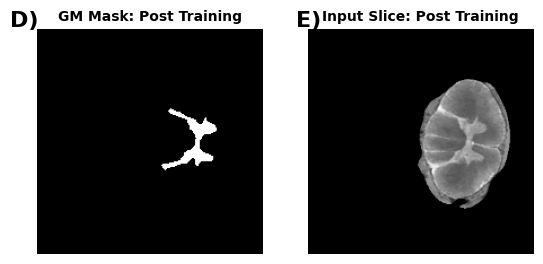

In [89]:

idx = np.argwhere(train_idx == 200)
plt.subplot(1,2,1)
plt.imshow(train_gm_mask[0,:,:,0].squeeze(), cmap='gray')
plt.text(-0.12, 1.08, "D)", transform=plt.gca().transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
plt.title("GM Mask: Post Training", fontsize=10, fontweight='bold')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(input_slice[0,:,:,0].squeeze(), cmap='gray')
plt.text(-0.05, 1.08, "E)", transform=plt.gca().transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
plt.title("Input Slice: Post Training", fontsize=10, fontweight='bold')
plt.axis("off")
plt.savefig("figures/CNN_GM_post_training_example_slice.svg", dpi = 1000)


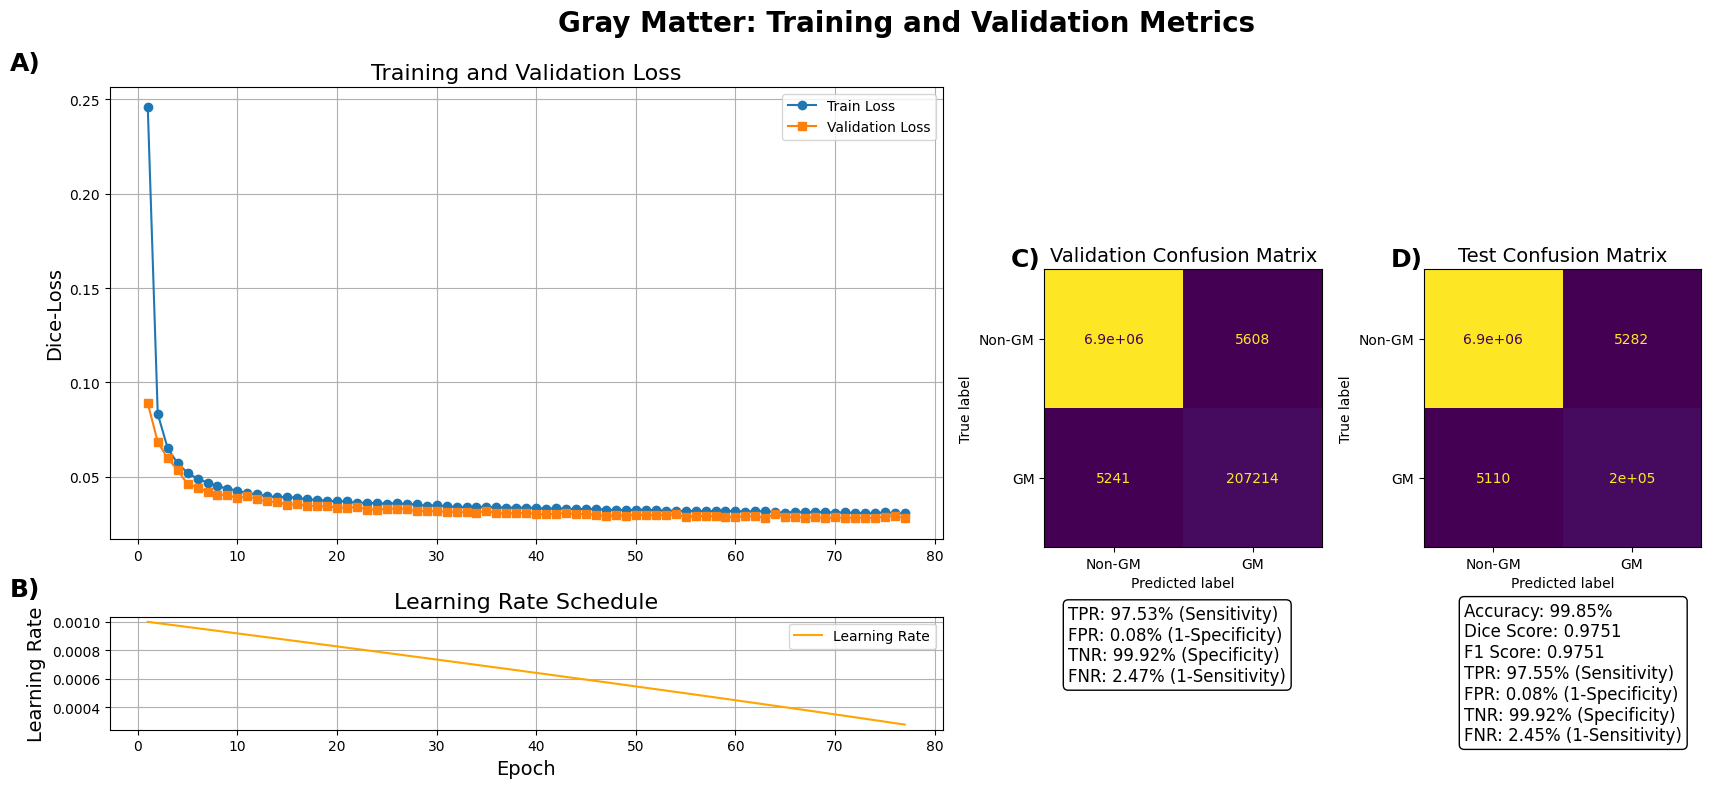

In [46]:
import matplotlib.gridspec as gridspec

# Create a figure with 2 rows and 3 columns, rightmost columns for confusion matrices
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1], height_ratios=[1, 0.25])

# Top left: Training and Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_loss, label='Train Loss', marker='o')
ax1.plot(epochs, val_loss, label='Validation Loss', marker='s')
ax1.set_ylabel('Dice-Loss', fontsize=14)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.legend()
ax1.grid(True)
ax1.text(-0.12, 1.08, "A)", transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# Bottom left: Learning Rate Schedule
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.plot(epochs, learning_rates, label='Learning Rate', color='orange')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Learning Rate', fontsize=14)
ax2.set_title('Learning Rate Schedule', fontsize=16)
ax2.legend()
ax2.grid(True)
ax2.text(-0.12, 1.35, "B)", transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# Validation Confusion Matrix (middle column)
ax_cm_val = fig.add_subplot(gs[:, 1])
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp_val.plot(ax=ax_cm_val, colorbar=False)
ax_cm_val.set_title("Validation Confusion Matrix", fontsize=14)
ax_cm_val.text(-0.12, 1.08, "C)", transform=ax_cm_val.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
# Add text for validation
textstr = (
    f"TPR: {TPR:.2f}% (Sensitivity)\n"
    f"FPR: {FPR:.2f}% (1-Specificity)\n"
    f"TNR: {TNR:.2f}% (Specificity)\n"
    f"FNR: {FNR:.2f}% (1-Sensitivity)"
)

fig.text(0.59, 0.21-0.025, textstr, fontsize=12, va='center', ha='left', bbox=dict(boxstyle="round", fc="w"))

# Test Confusion Matrix (right column)
ax_cm_test = fig.add_subplot(gs[:, 2])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classes)
disp_test.plot(ax=ax_cm_test, colorbar=False)
ax_cm_test.set_title("Test Confusion Matrix",fontsize = 14)
ax_cm_test.text(-0.12, 1.08, "D)", transform=ax_cm_test.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
# Add text for test

test_textstr = (
    f"Accuracy: {accuracy_test_gm:.2f}%\n"
    f"Dice Score: {dice_score_test_gm:.4f}\n"
    f"F1 Score: {f1_test_gm:.4f}\n"
    f"TPR: {TPR_test:.2f}% (Sensitivity)\n"
    f"FPR: {FPR_test:.2f}% (1-Specificity)\n"
    f"TNR: {TNR_test:.2f}% (Specificity)\n"
    f"FNR: {FNR_test:.2f}% (1-Sensitivity)"
)
fig.text(0.81, 0.15, test_textstr, fontsize=12, va='center', ha='left', bbox=dict(boxstyle="round", fc="w"))

plt.suptitle("Gray Matter: Training and Validation Metrics", fontsize= 20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 1])

plt.savefig("figures/CNN_training_validation_metrics_GM.svg", dpi = 2000)
plt.show()


## WM Segmentation

Augmented Data

In [ ]:
### Final Model ####
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

max_epochs = 100
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_wm_augment,
            val_loader =  validation_loader_wm, 
            criterion = dice_loss, 
            optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001), 
            scheduler = PolyLRScheduler(optimizer, max_epochs, power=0.9),
            max_epochs = max_epochs,
            start_epoch = 0,
            device = device, 
            save_path_model= 'Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_',
            min_delta= 1e-4, patience= 5)

In [ ]:
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")


max_epochs = 100
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_wm_augment,
            test_loader = validation_loader_wm, 
            criterion = dice_loss, 
            optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001), 
            scheduler = PolyLRScheduler(optimizer, max_epochs, power=0.9),
            max_epochs = max_epochs ,
            start_epoch= 0,
            device = device, 
            save_path_model= 'Segmentation Models/WM_augmented_data/sct_deepseg_wm_augmented_data_')

In [ ]:
# Your ONNX model path
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = pytorch_model.to(device= device)
print(f"Running on {device}")


#load parameters of previously trained model model
checkpoint = torch.load("C:/DTI_SC/humanSC_400h/Segmentation Models/WM_augmented_data/sct_deepseg_wm_augmented_data_40of100.pth", weights_only= False)

# 2. Restore optimizer and scheduler if continuing training
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


scheduler = PolyLRScheduler(optimizer, max_epochs=100, power=0.9)
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# 3. Optional: restore epoch to continue training
start_epoch = checkpoint['epoch'] + 1
pytorch_model.validation_history = checkpoint["validation_history"]


# 4. Load the model state dictionary
pytorch_model.load_state_dict(checkpoint['model_state_dict'])
pytorch_model = pytorch_model.to(device= device)
print(f"Model loaded successfully from: {checkpoint['model_state_dict']}")

print(f"Resuming training from epoch {start_epoch + 1}")


#continue training or evaluation as needed
max_epochs = 100

trained_model = train_model(pytorch_model = pytorch_model, 
            train_loader = Train_loader_wm_augment,
            test_loader = validation_loader_wm, 
            criterion = dice_loss, 
            optimizer =  optimizer, 
            scheduler = scheduler,
            max_epochs = max_epochs ,
            start_epoch= start_epoch,
            device = device, 
            save_path_model= 'Segmentation Models/WM_augmented_data/sct_deepseg_wm_augmented_data_')


### Validation Hyperparameter Tuning and Plots

In [26]:
############## Find the optimal quantizer function for classification ############
val_wm_mask, val_wm_mask_prob = predict_and_visualize(data_tensor = dataset_val_wm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= 0.5)

y_true_wm = dataset_val_wm.tensors[1].cpu().numpy().flatten()
y_probs_wm = val_wm_mask_prob.cpu().numpy().flatten()



# Youden's J
best_thresh_WM_youden = find_best_youden_threshold(y_true_wm, y_probs_wm)
print(f"Best Threshold (Youden's J): {best_thresh_WM_youden:.3f}")

# MCC
best_thresh_WM_MCC = find_best_mcc_threshold(y_true_wm, y_probs_wm)
print(f"Best Threshold (MCC): {best_thresh_WM_MCC:.3f}")

#F1 Threshold
best_threshold_WM_f1, best_f1_WM = find_best_f1_threshold(y_true = y_true_wm, y_probs = y_probs_wm)

import pickle

# Save the variables to a file
with open('Segmentation Models/thresholds/best_thresholds_WM.pkl', 'wb') as f:
    pickle.dump({
        'best_f1_WM': best_threshold_WM_f1,
        'best_thresh_WM_MCC': best_thresh_WM_MCC,
        'best_thresh_WM_youden': best_thresh_WM_youden
    }, f)
print("Thresholds saved successfully.")

best_threshold_WM_f1, best_thresh_WM_MCC,  best_thresh_WM_youden

Running on cuda
starting new
Best Threshold (Youden's J): 0.000
Trying Threshold: 0.0
Trying Threshold: 0.010101010101010102
Trying Threshold: 0.020202020202020204
Trying Threshold: 0.030303030303030304
Trying Threshold: 0.04040404040404041
Trying Threshold: 0.05050505050505051
Trying Threshold: 0.06060606060606061
Trying Threshold: 0.07070707070707072
Trying Threshold: 0.08080808080808081
Trying Threshold: 0.09090909090909091
Trying Threshold: 0.10101010101010102
Trying Threshold: 0.11111111111111112
Trying Threshold: 0.12121212121212122
Trying Threshold: 0.13131313131313133
Trying Threshold: 0.14141414141414144
Trying Threshold: 0.15151515151515152
Trying Threshold: 0.16161616161616163
Trying Threshold: 0.17171717171717174
Trying Threshold: 0.18181818181818182
Trying Threshold: 0.19191919191919193
Trying Threshold: 0.20202020202020204
Trying Threshold: 0.21212121212121213
Trying Threshold: 0.22222222222222224
Trying Threshold: 0.23232323232323235
Trying Threshold: 0.24242424242424243

(np.float64(0.19191919191919193),
 np.float64(0.19191919191919193),
 np.float32(1.0056058e-05))

**Plot for WM Segmentation**

In [90]:
## Learning Rate
wm_model = torch.load("Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth")
history = wm_model["validation_history"]

last_epoch = history[-1]["epoch"]
learning_rates = get_learning_rate(num_epochs= last_epoch, max_epochs=100)

val_loss = [epoch['loss'] for epoch in history]
train_loss = [epoch['train_loss'] for epoch in history]
epochs = [epoch['epoch'] for epoch in history]


####  Load the saved thresholds  WM ####
with open('Segmentation Models/thresholds/best_thresholds_WM.pkl', 'rb') as f:
    thresholds_wm = pickle.load(f)

# Unpack them into variables if needed
best_threshold_WM_f1 = thresholds_wm['best_f1_WM']
best_thresh_WM_MCC = thresholds_wm['best_thresh_WM_MCC']
best_thresh_WM_youden = thresholds_wm['best_thresh_WM_youden']
print(f"Best Threshold (Youden's J): {best_thresh_WM_youden:.3f}")
print(f"Best Threshold (MCC): {best_thresh_WM_MCC:.10f}")
print(f"Best Threshold (F1): {best_threshold_WM_f1:.10f}")

#### Validation SET ######
val_wm_mask, val_wm_mask_prob = predict_and_visualize(data_tensor = dataset_val_wm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= best_threshold_WM_f1)
y_true_wm = dataset_val_wm.tensors[1].cpu().numpy()


###### Confusion Matrix #########
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten the arrays for confusion matrix calculation
y_pred_flat = val_wm_mask.flatten()
y_true_flat = y_true_wm.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Calculate percentages
tn, fp, fn, tp = cm.ravel()

TPR = tp / (tp + fn) *100 if (tp + fn) > 0 else 0
TNR = tn / (tn + fp) *100 if (tn + fp) > 0 else 0
FPR = fp / (fp + tn) *100 if (fp + tn) > 0 else 0
FNR = fn / (fn + tp) *100 if (fn + tp) > 0 else 0

classes = ["Non-WM", "WM"]

# Add text with percentages
textstr = (
    f"TPR: {TPR:.2f}% (Sensitivity)\n"
    f"FPR: {FPR:.2f}% (1-Specificity)\n"
    f"TNR: {TNR:.2f}% (Specificity)\n"
    f"FNR: {FNR:.2f}% (1-Sensitivity)"
)

########## Test Dataset ########

test_wm_mask, test_wm_mask_prob = predict_and_visualize(data_tensor = dataset_test_wm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= "Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth", 
                    plot = False, 
                    plot_increment= 4,
                    threshold= best_threshold_WM_f1)
y_test_true_wm = dataset_test_wm.tensors[1].cpu().numpy()

# Flatten the arrays for confusion matrix calculation
y_test_pred_flat = test_wm_mask.flatten()
y_test_true_flat = y_test_true_wm.flatten()

# Compute confusion matrix
cm_test = confusion_matrix(y_test_true_flat, y_test_pred_flat)

# Calculate percentages
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

TPR_test = tp_test / (tp_test + fn_test) *100 if (tp_test + fn_test) > 0 else 0
TNR_test = tn_test / (tn_test + fp_test) *100 if (tn_test + fp_test) > 0 else 0
FPR_test = fp_test / (fp_test + tn_test) *100 if (fp_test + tn_test) > 0 else 0
FNR_test = fn_test / (fn_test + tp_test) *100 if (fn_test + tp_test) > 0 else 0


accuracy_test_wm = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test) * 100
dice_score_test_wm = dice_score(pred = y_test_pred_flat, target = y_test_true_flat)
f1_test_wm = f1_score(y_test_pred_flat, y_test_true_flat)

test_textstr = (
    f"Accuracy: {accuracy_test_wm:.2f}%\n"
    f"Dice Score: {dice_score_test_wm:.2f}%\n"
    f"F1 Score: {f1_test_wm:.2f}%\n"
    f"TPR: {TPR_test:.2f}% (Sensitivity)\n"
    f"FPR: {FPR_test:.2f}% (1-Specificity)\n"
    f"TNR: {TNR_test:.2f}% (Specificity)\n"
    f"FNR: {FNR_test:.2f}% (1-Sensitivity)"
)

c:\Users\sigur\miniconda3\envs\Pytorch_working\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Best Threshold (Youden's J): 0.000
Best Threshold (MCC): 0.1919191919
Best Threshold (F1): 0.1919191919
Running on cuda
starting new
Running on cuda
starting new


In [91]:
history[-1]

{'loss': 0.013917982578277588,
 'true_positive': 872592,
 'false_positive': 11171,
 'true_negative': 6223668,
 'false_negative': 12569,
 'accuracy': 0.9966657303370786,
 'auc': 0.9977019572063288,
 'epoch': 72,
 'train_loss': 0.015797619443190726}

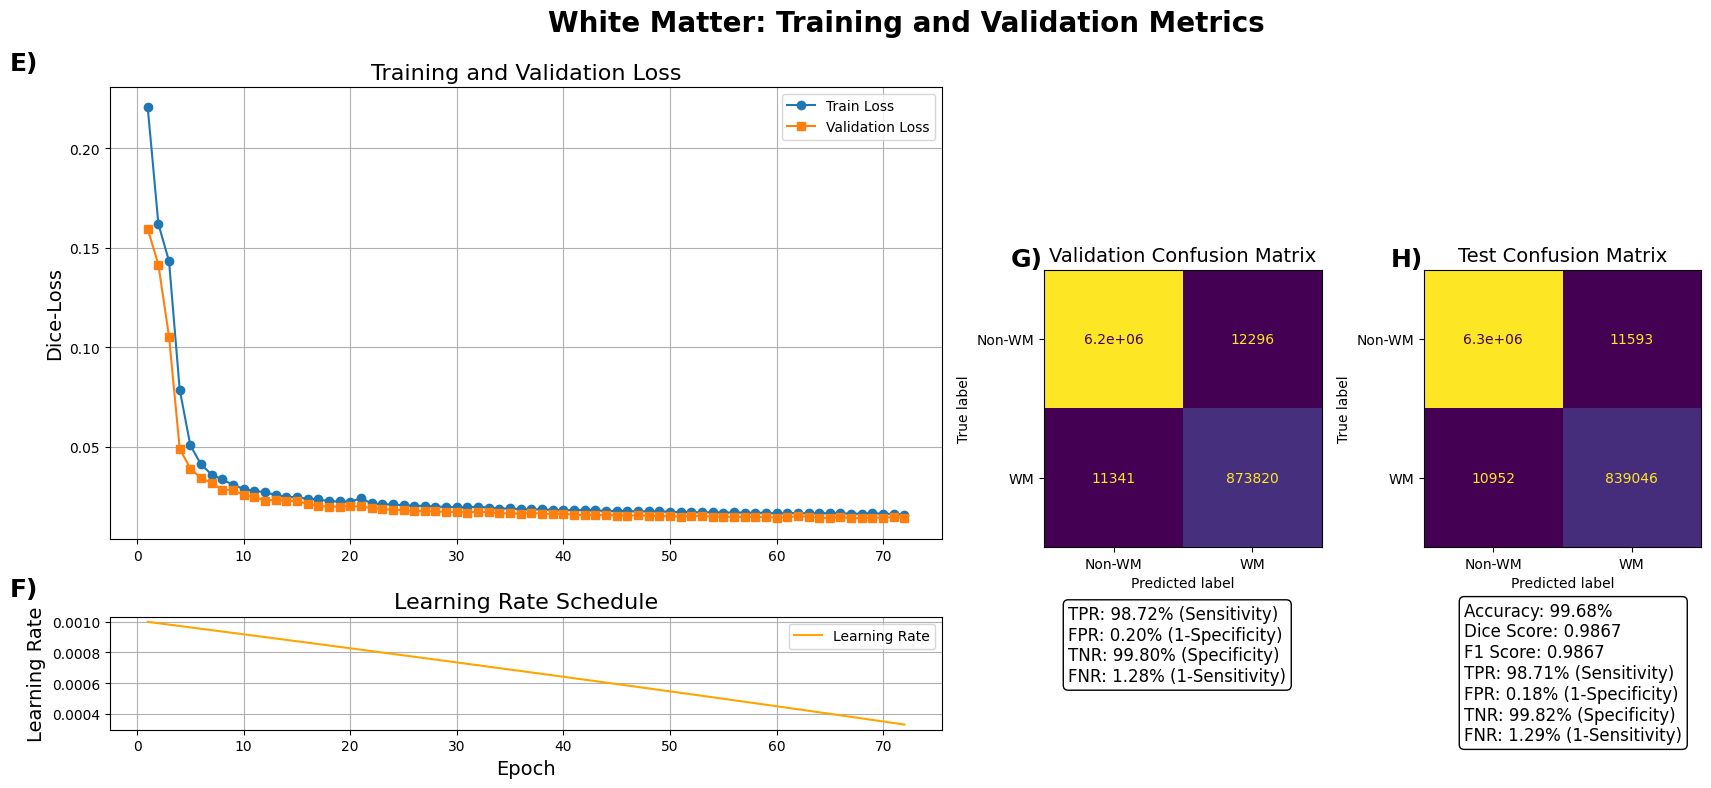

In [48]:
import matplotlib.gridspec as gridspec

# Create a figure with 2 rows and 3 columns, rightmost columns for confusion matrices
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1], height_ratios=[1, 0.25])

# Top left: Training and Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_loss, label='Train Loss', marker='o')
ax1.plot(epochs, val_loss, label='Validation Loss', marker='s')
ax1.set_ylabel('Dice-Loss', fontsize=14)
ax1.set_title('Training and Validation Loss', fontsize = 16)
ax1.legend()
ax1.grid(True)
ax1.text(-0.12, 1.08, "E)", transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# Bottom left: Learning Rate Schedule
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.plot(epochs, learning_rates, label='Learning Rate', color='orange')
ax2.set_xlabel('Epoch', fontsize = 14)
ax2.set_ylabel('Learning Rate', fontsize=14)
ax2.set_title('Learning Rate Schedule', fontsize=16)
ax2.legend()
ax2.grid(True)
ax2.text(-0.12, 1.35, "F)", transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')

# Validation Confusion Matrix (middle column)
ax_cm_val = fig.add_subplot(gs[:, 1])
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp_val.plot(ax=ax_cm_val, colorbar=False)
ax_cm_val.set_title("Validation Confusion Matrix",fontsize = 14)
ax_cm_val.text(-0.12, 1.08, "G)", transform=ax_cm_val.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
# Add text for validation
textstr = (
    f"TPR: {TPR:.2f}% (Sensitivity)\n"
    f"FPR: {FPR:.2f}% (1-Specificity)\n"
    f"TNR: {TNR:.2f}% (Specificity)\n"
    f"FNR: {FNR:.2f}% (1-Sensitivity)"
)

fig.text(0.59, 0.21-0.025, textstr, fontsize=12, va='center', ha='left', bbox=dict(boxstyle="round", fc="w"))

# Test Confusion Matrix (right column)
ax_cm_test = fig.add_subplot(gs[:, 2])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=classes)
disp_test.plot(ax=ax_cm_test, colorbar=False)
ax_cm_test.set_title("Test Confusion Matrix",fontsize = 14)
ax_cm_test.text(-0.12, 1.08, "H)", transform=ax_cm_test.transAxes, fontsize=18, fontweight='bold', va='top', ha='left')
# Add text for test

test_textstr = (
    f"Accuracy: {accuracy_test_wm:.2f}%\n"
    f"Dice Score: {dice_score_test_wm:.4f}\n"
    f"F1 Score: {f1_test_wm:.4f}\n"
    f"TPR: {TPR_test:.2f}% (Sensitivity)\n"
    f"FPR: {FPR_test:.2f}% (1-Specificity)\n"
    f"TNR: {TNR_test:.2f}% (Specificity)\n"
    f"FNR: {FNR_test:.2f}% (1-Sensitivity)"
)
fig.text(0.81, 0.15, test_textstr, fontsize=12, va='center', ha='left', bbox=dict(boxstyle="round", fc="w"))

plt.suptitle("White Matter: Training and Validation Metrics", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 1])

plt.savefig("figures/CNN_training_validation_metrics_WM.svg", dpi = 2000)
plt.show()


# Save Model as ONNX

In [11]:
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = pytorch_model.to(device= "cpu")
print(f"Running on {device}")

weights_file= "Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth"
#Load model Weights
checkpoint = torch.load(weights_file, map_location="cpu",  weights_only= False)
pytorch_model.load_state_dict(checkpoint['model_state_dict'])

# Save the PyTorch model as an ONNX file
dummy_input = torch.randn(1, 200, 200, 1).to("cpu")  # Adjust shape as needed
onnx_save_path = "Segmentation Models/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.onnx"
torch.onnx.export(
    pytorch_model.to("cpu"),  # Ensure model is on CPU
    dummy_input,
    onnx_save_path
)
print(f"Model saved as ONNX at: {onnx_save_path}")

Running on cuda
Model saved as ONNX at: Segmentation Models/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.onnx


C:\Users\sigur\AppData\Local\Temp\ipykernel_40940\2681785206.py:19: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [10]:
onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
onnx.checker.check_model(onnx_model)  # Check if the model is valid
pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model = pytorch_model.to(device= "cpu")
print(f"Running on {device}")

weights_file = "C:\DTI_SC\humanSC_400h\Segmentation Models\WM_augmented_intentiy_norm_data\sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth"

#Load model Weights
checkpoint = torch.load(weights_file, map_location="cpu",  weights_only= False)
pytorch_model.load_state_dict(checkpoint['model_state_dict'])

# Save the PyTorch model as an ONNX file
dummy_input = torch.randn(1, 200, 200, 1).to("cpu")  # Adjust shape as needed
onnx_save_path = "Segmentation Models/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.onnx"
torch.onnx.export(
    pytorch_model.to("cpu"),  # Ensure model is on CPU
    dummy_input,
    onnx_save_path
)
print(f"Model saved as ONNX at: {onnx_save_path}")

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
C:\Users\sigur\AppData\Local\Temp\ipykernel_40940\328260681.py:11: SyntaxWarning: invalid escape sequence '\D'
  weights_file = "C:\DTI_SC\humanSC_400h\Segmentation Models\WM_augmented_intentiy_norm_data\sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth"
C:\Users\sigur\AppData\Local\Temp\ipykernel_40940\328260681.py:20: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tut

Running on cuda
Model saved as ONNX at: Segmentation Models/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.onnx


# Validate the model on Test Set:



## Functions to validate the results

In [ ]:
from functions.pytorch_assist_functions import *

In [137]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def post_process_mask_test(mask_flat, gt_flat, remove_background = False, print_results = True):
    if remove_background:
        # Remove background (0) from both mask and ground truth
        mask_flat = mask_flat[gt_flat != 0]
        gt_flat = gt_flat[gt_flat != 0]


    acc = accuracy_score(gt_flat, mask_flat)
    f1 = f1_score(gt_flat, mask_flat, average='macro')
    cm = confusion_matrix(gt_flat, mask_flat)

    # Calculate Dice loss for flat arrays
    intersection = np.sum(mask_flat == gt_flat) * 2
    dice = intersection / (np.sum(mask_flat) + np.sum(gt_flat) + 1e-8)
 

    results = np.array([('accuracy', acc), ('f1_macro', f1), ('confusion_matrix', cm), ('dice', dice)],
                       dtype=object)

    if print_results:
        print("\nResults:")
        print(f" (GM) Accuracy: {acc:.4f}")
        print(f" (GM) Macro F1 Score: {f1:.4f}")
        print(f" (GM) Dice Score: {dice:.4f}")
        print("\n Foreground Confusion Matrix:\n", cm)
    return results

In [ ]:
##### Validation Function ##### 
def evaluate_model(weights_file ,test_loader, criterion, device,threshold = 0.5):
    onnx_model_path = "c:/sct_6.4/data/deepseg_gm_models/large_model.onnx"
    onnx_model = onnx.load(onnx_model_path)  # Load the ONNX model
    onnx.checker.check_model(onnx_model)  # Check if the model is valid
    pytorch_model = convert(onnx_model)  # Convert the ONNX model to a PyTorch model

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pytorch_model = pytorch_model.to(device= device)
    print(f"Running on {device}")

    #Load model Weights
    checkpoint = torch.load(weights_file, map_location=device,  weights_only= False)
    pytorch_model.load_state_dict(checkpoint['model_state_dict'])
    pytorch_model.eval()  # Set the model to evaluation mode


    #Setup Data Structures:
    y_test_prediction = []  # Initialize a list to store predictions
    all_outputs = []  # Initialize a list to store all outputs

    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        false_positive = 0
        false_negative = 0
        true_positive = 0
        true_negative = 0

        for batch_idx, (batch_image, batch_labels) in enumerate(test_loader):
            batch_image = batch_image.to(device)  # Move to device
            batch_labels = batch_labels.to(device)  # Move to device

            # Model output
            outputs = pytorch_model(batch_image)
            all_outputs.append(outputs)  # Save the output

            # Apply threshold to get binary predictions
            predicted = torch.where(outputs > threshold, 1, 0)

            # Save predictions
            y_test_prediction.append(predicted.cpu().numpy())


            # Loss
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item()

            total += batch_labels.numel()
            correct += (predicted == batch_labels).sum().item()

            false_positive += ((predicted == 1) & (batch_labels == 0)).sum().item()
            false_negative += ((predicted == 0) & (batch_labels == 1)).sum().item()
            true_positive += ((predicted == 1) & (batch_labels == 1)).sum().item()
            true_negative += ((predicted == 0) & (batch_labels == 0)).sum().item()

        # Metrics
        avg_test_loss = test_loss / len(test_loader)
        accuracy = 100 * correct / total

        print(f"False Positive: {false_positive}")
        print(f"False Negative: {false_negative}")
        print(f"True Positive: {true_positive}")
        print(f"True Negative: {true_negative}")
        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {accuracy:.2f}%")

    # Convert y_test_prediction to a NumPy array and remove the second dimension
    y_test_prediction = np.squeeze(np.array(y_test_prediction))

    # Convert all_outputs to a tensor
    probablity_outputs = torch.cat(all_outputs, dim=0)

    return y_test_prediction, probablity_outputs, avg_test_loss, accuracy

## Predict on Test Data

### Find Optimal Threshold

In [ ]:
## Find the optimal quantizer function for classification ##
train_gm_mask, train_gm_mask_prob = predict_and_visualize(data_tensor = dataset_val_gm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= 'Segmentation Models/GM_augmented_data/sct_deepseg_gm_augmented_data_99of100.pth', 
                    plot = False, 
                    plot_increment= 4)

y_true_gm = dataset_val_gm.tensors[1].cpu().numpy().flatten()
y_probs_gm = train_gm_mask_prob.cpu().numpy().flatten()



# Youden's J
best_thresh_GM_youden = find_best_youden_threshold(y_true_gm, y_probs_gm)
print(f"Best Threshold (Youden's J): {best_thresh_GM_youden:.3f}")

# MCC
best_thresh_GM_MCC = find_best_mcc_threshold(y_true_gm, y_probs_gm)
print(f"Best Threshold (MCC): {best_thresh_GM_MCC:.3f}")

#F1 Threshold
best_threshold_GM_f1, best_f1_GM = find_best_f1_threshold(y_true = y_true_gm, y_probs = y_probs_gm)

import pickle

# Save the variables to a file
with open('Segmentation Models/thresholds/best_thresholds_GM.pkl', 'wb') as f:
    pickle.dump({
        'best_f1_GM': best_threshold_GM_f1,
        'best_thresh_GM_MCC': best_thresh_GM_MCC,
        'best_thresh_GM_youden': best_thresh_GM_youden
    }, f)
print("Thresholds saved successfully.")

best_threshold_GM_f1, best_thresh_GM_MCC,  best_thresh_GM_youden

In [ ]:
## Find the optimal quantizer function for classification ##
train_wm_mask, train_wm_mask_prob = predict_and_visualize(data_tensor = dataset_val_wm.tensors[0],
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= 'Segmentation Models/WM_augmented_data/sct_deepseg_wm_augmented_data_99of100.pth', 
                    plot = False, 
                    plot_increment= 4)

y_true_wm = dataset_val_wm.tensors[1].cpu().numpy().flatten()
y_probs_wm = train_wm_mask_prob.cpu().numpy().flatten()


# Youden's J
best_thresh_WM_youden = find_best_youden_threshold(y_true_wm, y_probs_wm)
print(f"Best Threshold (Youden's J): {best_thresh_WM_youden:.3f}")

# MCC
best_thresh_WM_MCC = find_best_mcc_threshold(y_true_wm, y_probs_wm)
print(f"Best Threshold (MCC): {best_thresh_WM_MCC:.3f}")

#F1 Threshold
best_threshold_WM_f1, best_f1_WM = find_best_f1_threshold(y_true = y_true_wm, y_probs = y_probs_wm)

import pickle
# Save the variables to a file
with open('Segmentation Models/thresholds/best_thresholds_WM.pkl', 'wb') as f:
    pickle.dump({
        'best_f1_WM': best_threshold_WM_f1,
        'best_thresh_WM_MCC': best_thresh_WM_MCC,
        'best_thresh_WM_youden': best_thresh_WM_youden
    }, f)

print("Thresholds saved successfully.")

best_threshold_WM_f1, best_thresh_WM_MCC,  best_thresh_WM_youden

In [ ]:
####  Load the saved thresholds  WM ####
with open('Segmentation Models/thresholds/best_thresholds_WM.pkl', 'rb') as f:
    thresholds_wm = pickle.load(f)

# Unpack them into variables if needed
best_threshold_WM_f1 = thresholds_wm['best_f1_WM']
best_thresh_WM_MCC = thresholds_wm['best_thresh_WM_MCC']
best_thresh_WM_youden = thresholds_wm['best_thresh_WM_youden']
print(f"Best Threshold (Youden's J): {best_thresh_WM_youden:.3f}")
print(f"Best Threshold (MCC): {best_thresh_WM_MCC:.10f}")
print(f"Best Threshold (F1): {best_threshold_WM_f1:.10f}")


####  Load the saved thresholds  Gm ####
with open('Segmentation Models/thresholds/best_thresholds_GM.pkl', 'rb') as f:
    thresholds_gm = pickle.load(f)

# Unpack them into variables if needed
best_threshold_GM_f1 = thresholds_gm['best_f1_GM']
best_thresh_GM_MCC = thresholds_gm['best_thresh_GM_MCC']
best_thresh_GM_youden = thresholds_gm['best_thresh_GM_youden']
print(f"Best Threshold (Youden's J): {best_thresh_GM_youden:.3f}")
print(f"Best Threshold (MCC): {best_thresh_GM_MCC:.3f}")
print(f"Best Threshold (F1): {best_threshold_GM_f1:.3f}")

### Start WM and GM Segmentation

In [ ]:
##### WM mask Test Set #####
print("----------- Starting WM Mask test -------------")
y_test_prediction_wm, probablity_outputs_wm, avg_test_loss_wm, accuracy_wm = evaluate_model(test_loader= test_loader_wm,
                                                                                weights_file= 'Segmentation Models/WM_augmented_data/sct_deepseg_wm_augmented_data_99of100.pth', 
                                                                                criterion= dice_loss,
                                                                                device= device,
                                                                                threshold = best_threshold_WM_f1)

tpr = 845673 / (9958 + 845673) * 100
print(f"Percentage of True Positive Classified correctly = {tpr}")


#### Gm mask Test Set ##### 
print("----------- Starting Gm Mask test -------------")
y_test_prediction_gm, probablity_outputs_gm, avg_test_loss_gm, accuracy_gm = evaluate_model(test_loader= test_loader_gm,
                                                                                weights_file= 'Segmentation Models/GM_augmented_data/sct_deepseg_gm_augmented_data_99of100.pth', 
                                                                                criterion= dice_loss,
                                                                                device= device,
                                                                                threshold = best_threshold_GM_f1)
tpr = 208542 / (4220 + 208542) * 100
print(f"Percentage of True Positive Classified correctly = {tpr}")



#Combine the two Test Masks
combined_mask_test = np.zeros_like(y_test_prediction_gm)
# Set GM mask values to 1
combined_mask_test[y_test_prediction_gm == 1] = 1
# Set WM mask values to 2, overwriting GM values if both are present
combined_mask_test[y_test_prediction_wm == 1] = 2

In [ ]:
# Assume combined_mask_test is your predicted combined mask (shape: [z, h, w])
# Assume y_test_gm and y_test_wm are your ground truth tensors (shape: [z, h, w, 1])

# Convert ground truth GM and WM masks to numpy arrays and squeeze last dimension
gt_gm = y_test_gm.squeeze(-1).cpu().numpy()
gt_wm = y_test_wm.squeeze(-1).cpu().numpy()

# Create ground truth combined mask: 0=background, 1=GM, 2=WM (WM dominant)
gt_combined = np.zeros_like(gt_gm)
gt_combined[gt_gm == 1] = 1
gt_combined[gt_wm == 1] = 2

# Flatten for metric calculation
gt_flat = gt_combined.flatten()
pred_flat = combined_mask_test.flatten()

post_process_mask_test(pred_flat, gt_flat)


In [ ]:
# Mask out background (0) in ground truth
foreground_mask = gt_flat != 0

# Only consider foreground voxels
gt_fg = gt_flat[foreground_mask]
pred_fg = pred_flat[foreground_mask]

post_process_mask_test(pred_fg, gt_fg)


## Slice by slice (accuracy ~ z_xis):  

In [ ]:
##### WM mask Test Set #####
print("----------- Starting WM Mask test -------------")
## Find the optimal quantizer function for classification ##
FULL_wm_mask, FULL_wm_mask_prob = predict_and_visualize(data_tensor = dataset_full_wm.tensors[0],
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= 'Segmentation Models/WM_augmented_data/sct_deepseg_wm_augmented_data_99of100.pth', 
                    plot = False, 
                    plot_increment= 4)


FULL_gm_mask, FULL_gm_mask_prob = predict_and_visualize(data_tensor = dataset_full_gm.tensors[0], 
                    save = False,
                    save_path= None, 
                    device= device, 
                    weights_file= 'Segmentation Models/GM_augmented_data/sct_deepseg_gm_augmented_data_99of100.pth', 
                    plot = False, 
                    plot_increment= 4)

# Combine the two Test Masks
combined_mask_ALL = combine_mask(gm_mask = FULL_gm_mask, 
                                       wm_mask = FULL_wm_mask,
                                       )

In [144]:
gt_gm_ALL = dataset_full_gm.tensors[1].squeeze(-1).cpu().numpy()
gt_wm_ALL = dataset_full_wm.tensors[1].squeeze(-1).cpu().numpy()

# Create ground truth combined mask: 0=background, 1=GM, 2=WM (WM dominant)
gt_combined_ALL = np.zeros_like(gt_gm_ALL)
gt_combined_ALL[gt_gm_ALL == 1] = 1
gt_combined_ALL[gt_wm_ALL == 1] = 2

# Flatten for metric calculation
gt_flat_ALL = gt_combined_ALL.flatten()
pred_flat_ALL = combined_mask_ALL.flatten()

In [ ]:
import pandas as pd

all_metrics = []
for i in range(gt_combined_ALL.shape[0]):
    predict_temp = combined_mask_ALL[i, :, :, 0].flatten()
    gt_temp = gt_combined_ALL[i, :, :].flatten()
    print(f"Processing sample {i+1}/{gt_combined_ALL.shape[0]}")
    metrics = post_process_mask_test(predict_temp, gt_temp, print_results=False)
    
    # Convert metrics (np.array of tuples) to dict for DataFrame
    metrics_dict = {k: v for k, v in metrics}
    metrics_dict['slice'] = i
    all_metrics.append(metrics_dict)

metrics_df = pd.DataFrame(all_metrics)
metrics_df.head()

Processing sample 1/1814
Processing sample 2/1814
Processing sample 3/1814
Processing sample 4/1814
Processing sample 5/1814
Processing sample 6/1814
Processing sample 7/1814
Processing sample 8/1814
Processing sample 9/1814
Processing sample 10/1814
Processing sample 11/1814
Processing sample 12/1814
Processing sample 13/1814
Processing sample 14/1814
Processing sample 15/1814
Processing sample 16/1814
Processing sample 17/1814
Processing sample 18/1814
Processing sample 19/1814
Processing sample 20/1814
Processing sample 21/1814
Processing sample 22/1814
Processing sample 23/1814
Processing sample 24/1814
Processing sample 25/1814
Processing sample 26/1814
Processing sample 27/1814
Processing sample 28/1814
Processing sample 29/1814
Processing sample 30/1814
Processing sample 31/1814
Processing sample 32/1814
Processing sample 33/1814
Processing sample 34/1814
Processing sample 35/1814
Processing sample 36/1814
Processing sample 37/1814
Processing sample 38/1814
Processing sample 39/

,accuracy,f1_macro,confusion_matrix,dice,slice
0,0.997225,0.938231,"[[39048, 0, 36], [6, 456, 28], [12, 29, 385]]",29.276330,0
1,0.996700,0.924569,"[[38985, 0, 25], [3, 494, 74], [17, 13, 389]]",27.571231,1
2,0.997500,0.945336,"[[38962, 0, 11], [4, 527, 46], [23, 16, 411]]",26.995940,2
3,0.997225,0.941502,"[[38925, 0, 19], [3, 548, 57], [22, 10, 416]]",26.191070,3
4,0.996950,0.938408,"[[38896, 0, 12], [2, 560, 59], [39, 10, 422]]",25.571016,4


In [155]:
# Prepare empty lists to store the metrics for each slice
tp_percent_list = []
fp_percent_list = []
tn_percent_list = []
fn_percent_list = []

for idx, row in metrics_df.iterrows():
    cm = np.array(row['confusion_matrix'])
    tp = np.diag(cm)
    fn = cm.sum(axis=1) - tp
    fp = cm.sum(axis=0) - tp
    tn = cm.sum() - (tp + fp + fn)

    tp_percent = tp / cm.sum(axis=1) * 100
    fp_percent = fp / cm.sum(axis=0) * 100
    tn_percent = tn / cm.sum() * 100
    fn_percent = fn / cm.sum(axis=1) * 100

    # Save as lists of arrays (one array per slice)
    tp_percent_list.append(tp_percent)
    fp_percent_list.append(fp_percent)
    tn_percent_list.append(tn_percent)
    fn_percent_list.append(fn_percent)

# Add as new columns to the DataFrame
metrics_df['tp_percent'] = tp_percent_list
metrics_df['fp_percent'] = fp_percent_list
metrics_df['tn_percent'] = tn_percent_list
metrics_df['fn_percent'] = fn_percent_list


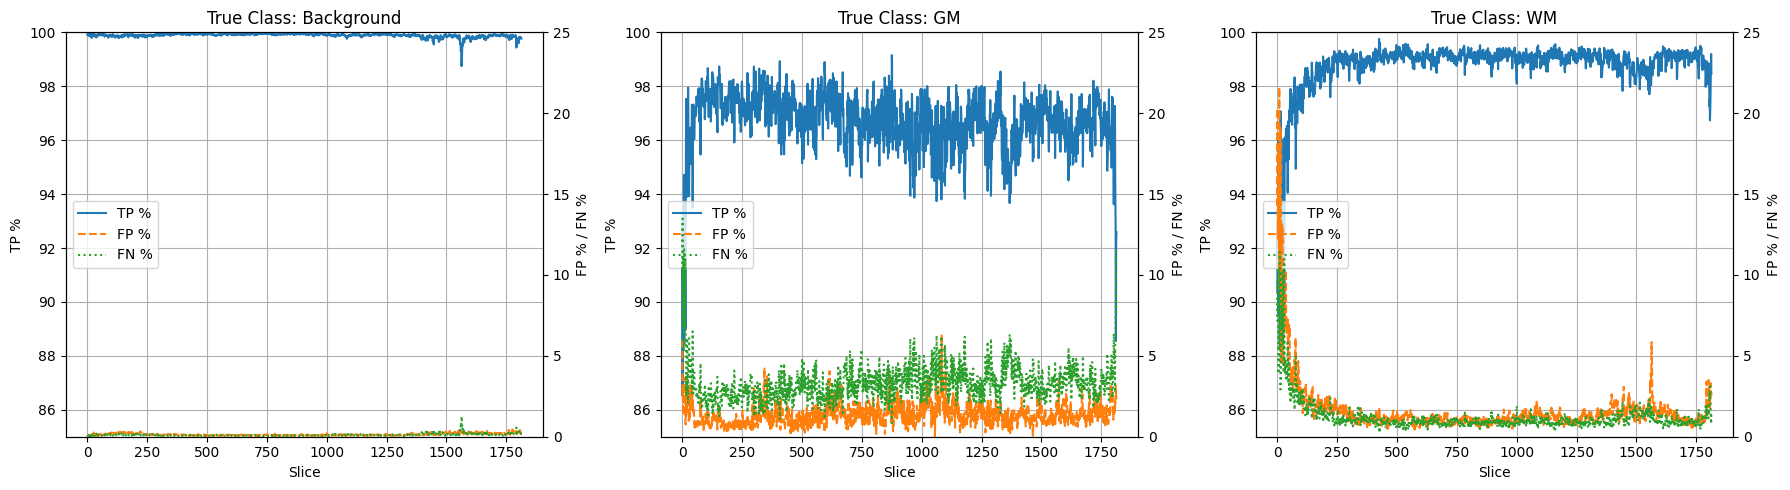

In [185]:
plt.figure(figsize=(18, 5))
class_names = ['Background', 'GM', 'WM']
num_classes = len(metrics_df['tp_percent'][0]) if hasattr(metrics_df['tp_percent'][0], '__iter__') else 1

for class_idx in range(num_classes):
    ax1 = plt.subplot(1, num_classes, class_idx + 1)
    tp_percent = [
        tp[class_idx] if hasattr(tp, '__iter__') else tp
        for tp in metrics_df['tp_percent']
    ]
    fp_percent = [
        fp[class_idx] if hasattr(fp, '__iter__') else fp
        for fp in metrics_df['fp_percent']
    ]
    fn_percent = [
        fn[class_idx] if hasattr(fn, '__iter__') else fn
        for fn in metrics_df['fn_percent']
    ]
    ax2 = ax1.twinx()
    # Swap: TP % on ax1 (left), FP/FN % on ax2 (right)
    ax1.plot(metrics_df['slice'], tp_percent, label='TP %', color='tab:blue')
    ax2.plot(metrics_df['slice'], fp_percent, '--', label='FP %', color='tab:orange')
    ax2.plot(metrics_df['slice'], fn_percent, ':', label='FN %', color='tab:green')
    ax1.set_xlabel('Slice')
    ax1.set_ylabel('TP %')
    ax2.set_ylabel('FP % / FN %')
    ax1.set_ylim(85, 100)  # Set TP % y-axis range between 85 and 100
    ax2.set_ylim(0, 25)    # Set FP/FN % y-axis range between 0 and 25
    ax1.set_title(f'True Class: {class_names[class_idx]}')
    ax1.grid(True)
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center left')

plt.tight_layout()
plt.show()

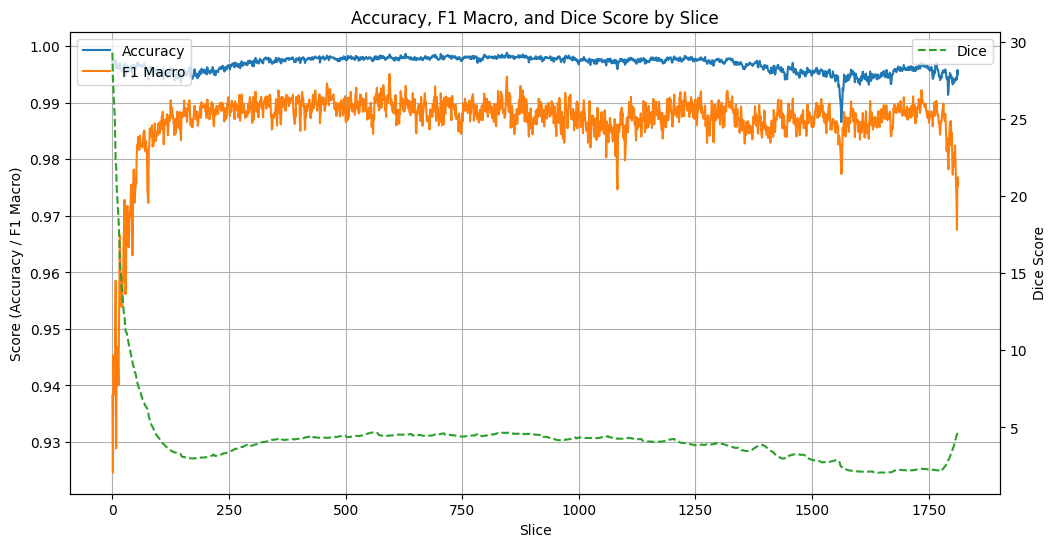

In [ ]:
                                                    # Plot accuracy and f1_macro on left y-axis, dice on right y-axis (due to different scale)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy and f1_macro
metrics_df.plot(x='slice', y='accuracy', ax=ax1, color='tab:blue', label='Accuracy')
metrics_df.plot(x='slice', y='f1_macro', ax=ax1, color='tab:orange', label='F1 Macro')
ax1.set_xlabel('Slice')
ax1.set_ylabel('Score (Accuracy / F1 Macro)')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for dice
ax2 = ax1.twinx()
metrics_df.plot(x='slice', y='dice', ax=ax2, color='tab:green', label='Dice', linestyle='--')
ax2.set_ylabel('Dice Score')
ax2.legend(loc='upper right')

plt.title('Accuracy, F1 Macro, and Dice Score by Slice')
plt.show()

# Post-Process Adjusting of the mask

### GM

In [112]:
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes

## Turn the GM mask into a binary mask ##
gm_mask_test = y_test_prediction_gm.astype(bool)
gm_mask_test_flat = gm_mask_test.flatten()
# Flatten the ground truth GM mask for comparison
gt_gm_flat = gt_gm.flatten() 

print("----------- Score Pre Post-Processing -------------")
post_process_mask_test(gm_mask_test_flat, gt_gm_flat)


#### Binary Opening ####
print("----------- Starting Binary Opening on GM Mask -------------")
gm_mask_test = binary_opening(gm_mask_test, structure=np.ones((3, 3, 3)))
gm_mask_test_flat = gm_mask_test.flatten()
post_process_mask_test(gm_mask_test_flat, gt_gm_flat)


#### Binary Closing ####
print("----------- Starting Binary Closing on GM Mask -------------")
gm_mask_test = binary_closing(gm_mask_test, structure=np.ones((3, 3, 3)))
gm_mask_test_flat = gm_mask_test.flatten()
post_process_mask_test(gm_mask_test_flat, gt_gm_flat)


#### Fill holes ####
print("----------- Filling Holes in GM Mask -------------")
gm_mask_test = binary_fill_holes(gm_mask_test)
gm_mask_test_flat = gm_mask_test.flatten()
post_process_mask_test(gm_mask_test_flat, gt_gm_flat)

#### Remove small objects (in 3D) #####
print("----------- Removing Small Objects in GM Mask -------------")
from skimage.morphology import remove_small_objects
gm_mask_test = remove_small_objects(gm_mask_test, min_size=100)
gm_mask_test_flat = gm_mask_test.flatten()
post_process_mask_test(gm_mask_test_flat, gt_gm_flat)



----------- Score Pre Post-Processing -------------
 (GM) Accuracy: 0.9988
 (GM) Macro F1 Score: 0.9898

 Foreground Confusion Matrix:
 [[7063017    4221]
 [   4220  208542]]
----------- Starting Binary Opening on GM Mask -------------
 (GM) Accuracy: 0.9747
 (GM) Macro F1 Score: 0.6140

 Foreground Confusion Matrix:
 [[7066902     336]
 [ 183585   29177]]
----------- Starting Binary Closing on GM Mask -------------
 (GM) Accuracy: 0.9746
 (GM) Macro F1 Score: 0.6141

 Foreground Confusion Matrix:
 [[7065756    1482]
 [ 183397   29365]]
----------- Filling Holes in GM Mask -------------
 (GM) Accuracy: 0.9746
 (GM) Macro F1 Score: 0.6141

 Foreground Confusion Matrix:
 [[7065756    1482]
 [ 183397   29365]]
----------- Removing Small Objects in GM Mask -------------
 (GM) Accuracy: 0.9744
 (GM) Macro F1 Score: 0.6096

 Foreground Confusion Matrix:
 [[7065780    1458]
 [ 184638   28124]]


array([['accuracy', 0.9744373626373627],
       ['f1_macro', 0.6095510833830906],
       ['confusion_matrix', array([[7065780,    1458],
                                   [ 184638,   28124]])]], dtype=object)

**Small Conclusion:**
Post-processing of the mask only really makes it worse.

### WM

In [121]:
## Turn the WM mask into a binary mask ##
wm_mask_test_pre = y_test_prediction_wm.astype(bool)
wm_mask_test_flat = wm_mask_test_pre.flatten()
# Flatten the ground truth WM mask for comparison
gt_wm_flat = gt_wm.flatten()

print("----------- Score Pre Post-Processing -------------")
post_process_mask_test(wm_mask_test_flat, gt_wm_flat)


#### Binary Opening ####
print("----------- Starting Binary Opening on WM Mask -------------")
wm_mask_test = binary_opening(wm_mask_test_pre, structure=np.ones((3, 3, 3)))
wm_mask_test_flat = wm_mask_test.flatten()
post_process_mask_test(wm_mask_test_flat, gt_wm_flat)


#### Binary Closing ####
print("----------- Starting Binary Closing on WM Mask -------------")
wm_mask_test = binary_closing(wm_mask_test_pre, structure=np.ones((3, 3, 3)))
wm_mask_test_flat = wm_mask_test.flatten()
post_process_mask_test(wm_mask_test_flat, gt_wm_flat)


#### Fill holes ####
print("----------- Filling Holes in WM Mask -------------")
wm_mask_test = binary_fill_holes(wm_mask_test_pre)
wm_mask_test_flat = wm_mask_test.flatten()
post_process_mask_test(wm_mask_test_flat, gt_wm_flat)

#### Remove small objects (in 3D) #####
print("----------- Removing Small Objects in WM Mask -------------")
from skimage.morphology import remove_small_objects
wm_mask_test = remove_small_objects(wm_mask_test_pre, min_size=100)
wm_mask_test_flat = wm_mask_test.flatten()
post_process_mask_test(wm_mask_test_flat, gt_wm_flat)

----------- Score Pre Post-Processing -------------
 (GM) Dice Score: 8.4788
 (GM) Accuracy: 0.9971
 (GM) Macro F1 Score: 0.9931
dice: 8.4788

 Foreground Confusion Matrix:
 [[6413384   10985]
 [   9958  845673]]
----------- Starting Binary Opening on WM Mask -------------
 (GM) Dice Score: 10.5703
 (GM) Accuracy: 0.9423
 (GM) Macro F1 Score: 0.8224
dice: 10.5703

 Foreground Confusion Matrix:
 [[6420996    3373]
 [ 416671  438960]]
----------- Starting Binary Closing on WM Mask -------------
 (GM) Dice Score: 6.8888
 (GM) Accuracy: 0.9541
 (GM) Macro F1 Score: 0.9039
dice: 6.8888

 Foreground Confusion Matrix:
 [[6104678  319691]
 [  14359  841272]]
----------- Filling Holes in WM Mask -------------
 (GM) Dice Score: 8.4786
 (GM) Accuracy: 0.9971
 (GM) Macro F1 Score: 0.9931
dice: 8.4786

 Foreground Confusion Matrix:
 [[6413364   11005]
 [   9944  845687]]
----------- Removing Small Objects in WM Mask -------------
 (GM) Dice Score: 8.4791
 (GM) Accuracy: 0.9971
 (GM) Macro F1 Score:

array([['accuracy', 0.9971292582417582],
       ['f1_macro', 0.9930838186821506],
       ['confusion_matrix', array([[6413434,   10935],
                                   [   9964,  845667]])],
       ['dice', np.float64(8.47910418733894)]], dtype=object)

# Predict on my Data

## Load in Data

First we start out by resizing our images to 200x200

In [3]:
# ROtated and Tranposed
RARE_rotated_BFC_resized = load_and_resize(path = "Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz",
                                       mask = False)

np.save("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_BFC_200_200.npy", RARE_rotated_BFC_resized)

# ROtated and Tranposed
RARE_rotated_resized = load_and_resize(path = "Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz",
                                       mask = False)

np.save("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_200_200.npy", RARE_rotated_resized)



# Tranposed
RARE_tranposed_resized = load_and_resize(path = "Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked.nii.gz",
                                       mask = False)
np.save("Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked_200_200.npy", RARE_tranposed_resized)


Then we make sure our images are flipped the same way as the training images

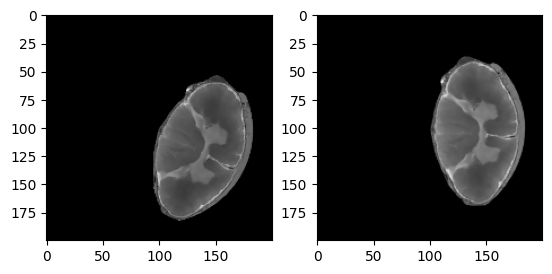

In [5]:
### RARE ROTATED AND TRanposed #####
RARE_all_200_200_rotated = np.load("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_200_200.npy")

#Tranpose % Flip to Match Training Data 
RARE_all_200_200_rotated_norm = normalize_slicewise_minmax(RARE_all_200_200_rotated , axis = 0)
RARE_all_200_200_rotated_norm = RARE_all_200_200_rotated_norm.transpose(0, 2, 1,3)
# Flip the y-axis (axis=2) of RARE_all_200_200_rotated_norm and ensure positive strides
RARE_all_200_200_rotated_norm = np.flip(RARE_all_200_200_rotated_norm, axis=2).copy()
#Turn into Tensor
RARE_200_200_rotated_norm_tensor = torch.tensor(RARE_all_200_200_rotated_norm, dtype=torch.float32)

##################### RARE TRANSPOSED #####
RARE_all_200_200_transposed = np.load("Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked_200_200.npy")

#Tranpose % Flip to Match Training Data 
RARE_all_200_200_transposed_norm = normalize_slicewise_minmax(RARE_all_200_200_transposed , axis = 0)
RARE_all_200_200_transposed_norm = RARE_all_200_200_transposed_norm.transpose(0, 2, 1,3)
# Flip the y-axis (axis=2) of RARE_all_200_200_transposed_norm and ensure positive strides
RARE_all_200_200_transposed_norm = np.flip(RARE_all_200_200_transposed_norm, axis=2).copy()
#Turn into Tensor
RARE_200_200_transposed_norm_tensor = torch.tensor(RARE_all_200_200_transposed_norm, dtype=torch.float32)



##### Create a TensorDataset ########
dataset_RARE_final = TensorDataset(RARE_200_200_rotated_norm_tensor)
RARE_loader = DataLoader(dataset_RARE_final, batch_size = 1)


#Visual Investigation that both imags look alike (Original an resized)
fig, axes = plt.subplots(1, 2)
#axes[0].imshow(RARE_all_200_200[100, :, :], cmap="gray")
axes[0].imshow(RARE_200_200_transposed_norm_tensor[100, :, :,0], cmap="gray")

axes[1].imshow(RARE_200_200_rotated_norm_tensor[100, :, :,0], cmap="gray")

plt.show()

In [ ]:
X_temp = dataset_val_gm.tensors[0]

from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt

# Create a figure
fig, ax = plt.subplots(figsize=(5, 5))

# Initialize the plot
img = ax.imshow(X_temp[0, :, :, 0].cpu(), cmap='gray')
ax.axis('off')

# Update function for the animation
def update(frame):
    img.set_data(X_temp[frame, :, :, 0].cpu())
    ax.set_title(f"Slice {frame}")

# Create the animation
ani = FuncAnimation(fig, update, frames=X_temp.shape[0], interval=100)

# Save the animation as a video or GIF
ani.save('slices_animation.gif', writer='pillow', fps=10)

plt.show()

### GM 

In [6]:
# Load the saved thresholds
with open('Segmentation Models/thresholds/best_thresholds_GM.pkl', 'rb') as f:
    thresholds_gm = pickle.load(f)

# Unpack them into variables if needed
best_threshold_GM_f1 = thresholds_gm['best_f1_GM']
best_thresh_GM_MCC = thresholds_gm['best_thresh_GM_MCC']
best_thresh_GM_youden = thresholds_gm['best_thresh_GM_youden']
print(f"Best Threshold (Youden's J): {best_thresh_GM_youden:.3f}")
print(f"Best Threshold (MCC): {best_thresh_GM_MCC:.3f}")
print(f"Best Threshold (F1): {best_threshold_GM_f1:.3f}")

Best Threshold (Youden's J): 0.000
Best Threshold (MCC): 0.232
Best Threshold (F1): 0.232


In [7]:
# Usage On Our Data for Classification Purpose
gm_mask, gm_mask_prob = predict_and_visualize(data_tensor = RARE_200_200_transposed_norm_tensor,
                    threshold= best_threshold_GM_f1,
                    save = True,
                    save_path= 'Combined_Data/Transposed/GM_mask_FINAL_f1_threshold.npy', 
                    device= device, 
                    weights_file = 'Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth', 
                    plot = False , 
                    plot_increment= 4)



Running on cuda
starting new


In [100]:
#Augmented and Rotated
gm_mask_aug_rotated, gm_mask_aug_rotated_prob = predict_and_visualize(data_tensor = RARE_200_200_rotated_norm_tensor,
                    threshold= best_threshold_GM_f1, 
                    save = True, 
                    save_path= 'Combined_Data/Rotated and Transposed/GM_mask_aug_rotated_FINAL_f1_threshold.npy', 
                    device= device, 
                    weights_file= 'Segmentation Models/GM_augmented_intentiy_norm_data/sct_deepseg_gm_augmented_intensity_norm_data_2_76of100.pth', 
                    plot = False,
                    plot_increment= 4)

Running on cuda
starting new


In [102]:
plot_all_slices(gm_mask_aug_rotated, z_axis = 0, pause = 0.2, increment = 5)

TypeError: plot_all_slices() got an unexpected keyword argument 'z_axis'

### WM

In [10]:
# Load the saved thresholds
with open('Segmentation Models/thresholds/best_thresholds_WM.pkl', 'rb') as f:
    thresholds_wm = pickle.load(f)

# Unpack them into variables if needed
best_threshold_WM_f1 = thresholds_wm['best_f1_WM']
best_thresh_WM_MCC = thresholds_wm['best_thresh_WM_MCC']
best_thresh_WM_youden = thresholds_wm['best_thresh_WM_youden']
print(f"Best Threshold (Youden's J): {best_thresh_WM_youden:.3f}")
print(f"Best Threshold (MCC): {best_thresh_WM_MCC:.10f}")
print(f"Best Threshold (F1): {best_threshold_WM_f1:.10f}")

Best Threshold (Youden's J): 0.000
Best Threshold (MCC): 0.1919191919
Best Threshold (F1): 0.1919191919


In [11]:
# Usage On Our Data for Classification Purpose
wm_mask, wm_mask_prob = predict_and_visualize(data_tensor = RARE_200_200_transposed_norm_tensor,
                    threshold= best_threshold_WM_f1,
                    save = True,
                    save_path= 'Combined_Data/Transposed/WM_mask_FINAL_f1_threshold.npy', 
                    device= device, 
                    weights_file= 'Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth', 
                    plot = False, 
                    plot_increment= 4)

Running on cuda
starting new


In [107]:
# Rotated and Augmented Training Data
wm_mask_rotated, wm_mask_rotated_prob = predict_and_visualize(data_tensor = RARE_200_200_rotated_norm_tensor,
                    threshold= best_threshold_WM_f1,
                    save = True,
                    save_path= 'Combined_Data/Rotated and Transposed/WM_mask_rotated_augmented_FINAL_f1_threshold.npy', 
                    device= device, 
                    weights_file= 'Segmentation Models/WM_augmented_intentiy_norm_data/sct_deepseg_wm_augmented_intensity_norm_data_2_71of100.pth', 
                    plot = False, 
                    plot_increment= 4)

Running on cuda
starting new


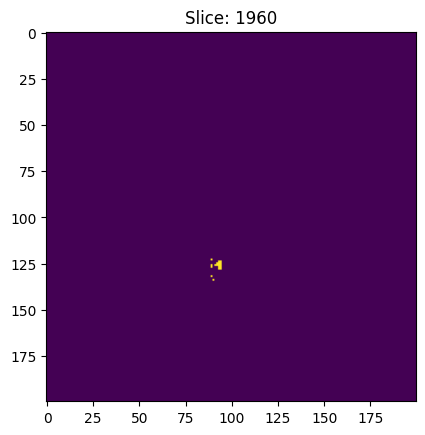

In [158]:
plot_all_slices(wm_mask_rotated, z_axis = 0, pause = 0.2, increment = 5)

### Combine Mask

After visual inspection we conclude that it's optimal to combine wm and gm mask by letting WM being dominant. I.e., if a voxle is classified as both a WM and GM voxel it will be classified as a WM mask. 

In [13]:
def combine_mask(gm_mask_path = None, wm_mask_path = None, gm_mask = None,wm_mask = None, output_path = None):
    if gm_mask is None:
        #Load the GM and WM masks
        gm_mask = np.load(gm_mask_path)
    if wm_mask is None:
        wm_mask = np.load(wm_mask_path)

    # Create a combined mask with the same shape as the input masks
    combined_mask = np.zeros_like(gm_mask)

    # Set GM mask values to 1
    combined_mask[gm_mask == 1] = 1

    # Set WM mask values to 2, overwriting GM values if both are present
    combined_mask[wm_mask == 1] = 2

    combined_mask = np.transpose(combined_mask, (0,1,2,3))
    
    
    if output_path != None:
        # Save the combined mask as a NIfTI file
        # Convert to int32 (or uint8 if the mask contains only 0s and 1s)
        combined_mask = combined_mask.astype(np.int32)  # or np.uint8
        combined_mask_nifti = nib.Nifti1Image(combined_mask, np.eye(4))
        nib.save(combined_mask_nifti, (output_path +".nii.gz"))

        np.save((output_path + ".npy"), combined_mask)
    return combined_mask


In [14]:
## TRy and Perofrm Binary dialtion GM mask before combining:
from scipy.ndimage import binary_dilation


## Rotated and Transposed

gm_mask_temp = np.load('Combined_Data/Rotated and Transposed/GM_mask_rotated_FINAL_f1_threshold.npy').squeeze()
gm_mask_dilated = binary_dilation(gm_mask_temp, structure=np.ones((3, 3, 3)), iterations=1)
gm_mask_dilated = np.expand_dims(gm_mask_dilated, axis=-1)  # Add last dimension to match original shape
gm_mask_dilated = gm_mask_dilated.astype(np.int32)  # Convert to int32
np.save('Combined_Data/Rotated and Transposed/GM_mask_rotated_FINAL_f1_threshold_dilated.npy', gm_mask_dilated)



### Tranposed
gm_mask_temp = np.load('Combined_Data/Transposed/GM_mask_FINAL_f1_threshold.npy').squeeze()
gm_mask_dilated = binary_dilation(gm_mask_temp, structure=np.ones((3, 3, 3)), iterations=1)
gm_mask_dilated = np.expand_dims(gm_mask_dilated, axis=-1)  # Add last dimension to match original shape
gm_mask_dilated = gm_mask_dilated.astype(np.int32)  # Convert to int32
np.save('Combined_Data/Transposed/GM_mask_FINAL_f1_threshold_dilated.npy', gm_mask_dilated)

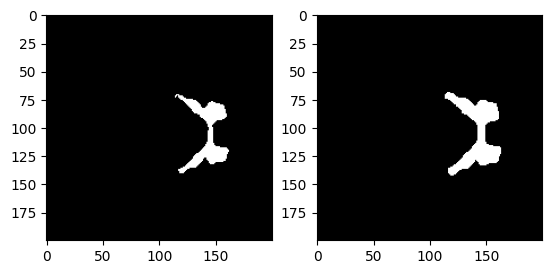

In [110]:
z = 100
plt.subplot(1,2,1)
plt.imshow(gm_mask_temp[z, :, :], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gm_mask_dilated[z, :, :], cmap='gray')

In [15]:
# Transposed
combined_mask = combine_mask(gm_mask_path = 'Combined_Data/Transposed/GM_mask_FINAL_f1_threshold_dilated.npy',
             wm_mask_path = 'Combined_Data/Transposed/WM_mask_FINAL_f1_threshold.npy',
             output_path = "Combined_Data/Transposed/Combined_GM_WM_mask_FINAL_f1_threshold_dilated")

In [ ]:
# Rotated and Transposed
combined_mask_gm_dialated = combine_mask(gm_mask_path = 'Combined_Data/Rotated and Transposed/GM_mask_rotated_FINAL_f1_threshold_dilated.npy',
             wm_mask_path = 'Combined_Data/Rotated and Transposed/WM_mask_rotated_augmented_FINAL_f1_threshold.npy',
             output_path = "Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM")

In [ ]:
# Resize combined_mask to shape (1965, 96, 96)
import torch.nn.functional as F


# Rotated and Tranposed
mask_to_resize = combined_mask_gm_dialated.squeeze()
# Convert to torch tensor and add batch/channel dims for interpolation
mask_tensor = torch.tensor(mask_to_resize, dtype=torch.float32)
mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, z, h, w)
# Resize using nearest neighbor to preserve labels
resized_mask = F.interpolate(mask_tensor, size=(mask_to_resize.shape[0], 96, 96), mode='nearest')
# Remove batch/channel dims and convert back to numpy
resized_mask_np = resized_mask.squeeze().numpy().astype(combined_mask_gm_dialated.dtype)

print("Resized mask shape:", resized_mask_np.shape)
np.save('Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy',resized_mask_np)



In [8]:

##### Create a .nii mask compatiable for AMICO NODDI Model. ########

resized_mask_np = np.load('Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.npy')
resized_mask_np = np.where(resized_mask_np == 1, 1, np.where(resized_mask_np == 2, 1, 0)).astype(bool)

resized_mask_np = np.transpose(resized_mask_np, (2, 1, 0))
resized_mask_np = np.flip(resized_mask_np, axis=0)

import nibabel as nib
DTI_combined_preproc_trans_masked_rotated = nib.load ("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")

# Save the resized mask as a NIfTI file
# Use the affine from DTI_combined_preproc_trans_masked_rotated
nifti_img = nib.Nifti1Image(resized_mask_np.astype(np.int32), DTI_combined_preproc_trans_masked_rotated.affine)
nib.save(nifti_img, 'Combined_Data/Rotated and Transposed/Combined_GM_WM_mask_aug_rotated_FINAL_f1_threshold_dilated_GM_96x96.nii.gz')

In [ ]:
n_voxel_count = resized_mask_np.flatten().__len__()
n_voxel_count_wm = resized_mask_np[resized_mask_np == 2].flatten().__len__()
n_voxel_count_gm = resized_mask_np[resized_mask_np == 1].flatten().__len__()

print(f"Total number of voxels in the mask: {n_voxel_count}")
print(f"Total number of white matter voxels: {n_voxel_count_wm}")
print(f"Total number of gray matter voxels: {n_voxel_count_gm}")
print(f"Total number of voxels gm + wm: {n_voxel_count_gm + n_voxel_count_wm}")

In [ ]:
### Tranposed 
mask_to_resize = combined_mask.squeeze()
# Convert to torch tensor and add batch/channel dims for interpolation
mask_tensor = torch.tensor(mask_to_resize, dtype=torch.float32)
mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, z, h, w)
# Resize using nearest neighbor to preserve labels
resized_mask = F.interpolate(mask_tensor, size=(mask_to_resize.shape[0], 96, 96), mode='nearest')
# Remove batch/channel dims and convert back to numpy
resized_mask_np = resized_mask.squeeze().numpy().astype(combined_mask.dtype)

print("Resized mask shape:", resized_mask_np.shape)
np.save('Combined_Data/Transposed/Combined_GM_WM_mask_aug_FINAL_f1_threshold_dilated_96x96.npy',resized_mask_np)


Resized mask shape: (1965, 96, 96)


In [3]:

##### Create a .nii mask compatiable for AMICO NODDI Model. ########
resized_mask_np = np.load('Combined_Data/Transposed/Combined_GM_WM_mask_aug_FINAL_f1_threshold_dilated_96x96.npy')
resized_mask_np = np.where(resized_mask_np == 1, 1, np.where(resized_mask_np == 2, 1, 0)).astype(bool)

resized_mask_np = np.transpose(resized_mask_np, (2, 1, 0))
resized_mask_np = np.flip(resized_mask_np, axis=0)

import nibabel as nib
DTI_combined_preproc_trans_masked = nib.load("Combined_Data/Transposed/DTI_combined_preproc_trans_masked.nii.gz")

# Save the resized mask as a NIfTI file
# Use the affine from DTI_combined_preproc_trans_masked_rotated
nifti_img = nib.Nifti1Image(resized_mask_np.astype(np.int32), DTI_combined_preproc_trans_masked.affine)
nib.save(nifti_img, 'Combined_Data/Transposed/Combined_GM_WM_mask_aug_FINAL_f1_threshold_dilated_96x96.nii.gz')

Total number of voxels in the mask: 18109440
Total number of white matter voxels: 1451951
Total number of gray matter voxels: 386497
Total number of voxels gm + wm: 1838448


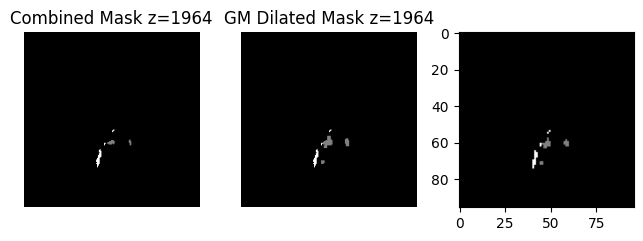

In [118]:
plt.figure(figsize=(12, 4 * 4))  # Adjust height for more subplots

num_slices = combined_mask.shape[0]
plot_idx = 1

for z in range(0, num_slices, 4):
    plt.subplot(1, 3, 1)
    plt.imshow(combined_mask[z, :, :], cmap='gray')
    plt.title(f'Combined Mask z={z}')
    plt.axis('off')

    plt.subplot(1, 3,2)
    plt.imshow(combined_mask_gm_dialated[z, :, :], cmap='gray')
    plt.title(f'GM Dilated Mask z={z}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(resized_mask_np[z, :, :], cmap='gray')

    plt.tight_layout()
    plt.show()
    IPython.display.clear_output(wait=True)



In [ ]:
wm_mask = np.load("Combined_Data/Rotated and Transposed/WM_mask_rotated_augmented_100epoch_f1_threshold.npy")
gm_mask = np.load("Combined_Data/Rotated and Transposed/GM_mask_aug_rotated_100epoch_f1_threshold.npy")
# Define the increment
increment = 4

# Loop through the z-axis with the specified increment
for z in range(0, combined_mask.shape[0], increment):
    if keyboard.is_pressed('esc'):
                print("Exiting loop...")
                break
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    # Plot GM mask
    axes[0].imshow(gm_mask[z, :, :, 0], cmap='gray')
    axes[0].set_title(f"GM Mask (Slice {z})")
    
    # Plot WM mask
    axes[1].imshow(wm_mask[z, :, :, 0], cmap='gray')
    axes[1].set_title(f"WM Mask (Slice {z})")
    
    # Plot combined mask
    axes[2].imshow(combined_mask[z, :, :, 0], cmap='gray')
    axes[2].set_title(f"Combined Mask (Slice {z})")


    axes[3].imshow(RARE_200_200_rotated_tensor[z, :, :, 0].cpu(), cmap="gray")


    axes[4].imshow(RARE_200_200_rotated_tensor[z, :, :, 0].cpu(), cmap="gray")
    axes[4].imshow(combined_mask[z, :, :, 0], alpha = .5)
    axes[4].set_title(f"WM DOM MASK (Slice {z+1}")


    
 
    display(fig)
    IPython.display.clear_output(wait=True)